## Imports and genertic functions

In [8]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_extra.cluster import KMedoids
import copy

In [9]:
for i in range(len(prices_F)):
    if round(prices_S[i], 0) > round(prices_F[i], 0):
        print("JA")
        break

In [564]:
g = np.array([31, 208, 130])
g/255

array([0.12156863, 0.81568627, 0.50980392])

In [3]:
red = (0.77, 0, 0.05) # (196, 0, 13)
blue = (0.12, 0.24, 1) # (31, 61, 255)
# green = (0.31, 1, 0.34) # (79, 255, 87)
green = (0.122, 00.816, 0.51) # (31, 208, 130)
navyblue = (0, 0, 0.4) # (0, 0, 102)
black = (0, 0, 0)
white = (1, 1, 1)
cgreen = (0.57254902, 0.7254902 , 0.51372549) # (146, 185, 131)
cblue = (0.70196078, 0.83137255, 1) # (179, 212, 255)

top_domain = 53.32 # 90% quantile

def get_hydro_opt(d, lh, ls, lb, max_elec):
    if ls > lh:
        return 0
    elif lb < lh:
        return max_elec
    else:
        return np.minimum(max_elec, np.maximum(0, d))

def import_consts(negative_prices=False):
    all_data = pd.read_csv("./data/2020_data.csv")
    prices_B = np.maximum(all_data["UP"].to_numpy(),0)
    prices_S = np.maximum(all_data["DW"].to_numpy(),0)
    prices_F = np.maximum(all_data["forward_RE"].to_numpy(),0)
    prices_forecast = np.maximum(all_data["forward_FC"].to_numpy(), 0)

    max_elec = 10
    max_wind = 10
    nominal_wind = 10
    min_production = 50


    features = all_data.loc[:, ["Offshore DK2", "Offshore DK1", "Onshore DK2", "Onshore DK1", "production_FC"]]
    features["forward"] = prices_F
    features_red = all_data.loc[:, ["production_FC"]]
    features_red["forward"] = prices_F
    realized = all_data.loc[:, "production_RE"].to_numpy()
    realized *= nominal_wind

    # forecast_production = all_data.loc[:, "production_FC"].to_numpy() * nominal_wind
    forecast_model_df = pd.read_csv("./results/2020_forecast_model.csv")
    forecast_production = forecast_model_df.loc[:,"forecast_production"]

    price_H = 35.199999999999996
    penalty = np.quantile(prices_B, 0.95) # 95% quantile of buying price over all 2 years
    # penalty = 2 * price_H
    # penalty = np.max(prices_B) # Something HIGHER is needed apparently

    return (
        prices_B,
        prices_S,
        prices_F,
        prices_forecast,
        features,
        features_red,
        realized,
        price_H,
        max_elec,
        nominal_wind,
        penalty,
        min_production,
        forecast_production
    )

def get_forward_1(qF, features, t, forecast_model):
    if forecast_model:
        return np.sum([qF.iloc[0, i]*features[i][t] for i in range(len(features))]) + qF.iloc[0, -1]
    else:
        return np.sum([qF.iloc[0, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qF.iloc[0, -1]

def get_forward_24(qF, features, t, forecast_model):
    hour_of_day = (t % 24)
    if forecast_model:
        return np.sum([qF.iloc[hour_of_day, i]*features[i][t] for i in range(len(features))]) + qF.iloc[hour_of_day, -1]
    else:
        return np.sum([qF.iloc[hour_of_day, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qF.iloc[hour_of_day, -1]


def get_hydro_1(qH, features, max_elec, t, forecast_model):
    if forecast_model:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[0, i]*features[i][t] for i in range(len(features))]) + qH.iloc[0, -1]))
    else:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[0, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qH.iloc[0, -1]))

def get_hydro_24(qH, features, max_elec, t, forecast_model):
    hour_of_day = (t % 24) 
    if forecast_model:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[hour_of_day, i]*features[i][t] for i in range(len(features))]) + qH.iloc[hour_of_day, -1]))
    else:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[hour_of_day, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qH.iloc[hour_of_day, -1]))

def get_scaled_objs(list_of_results):
    return [np.sum(result['obj'])/(1e6) for result in list_of_results]

def get_remaining_planned_hydro(df, features, max_elec, i):
    hour_of_day = (i % 24) 
    if (hour_of_day == 23):
        return 0
    remaining_hours = 23-hour_of_day
    return np.sum([get_hydro_24(df, features, max_elec, i+j)  for j in range(1, remaining_hours)])

def plot_resulting_objectives(values, names, figsize=(10,4), colors=None):
    xticks = names
    idx = np.asarray([i for i in range(len(xticks))])

    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xticks(idx, )
    ax.set_xticklabels(xticks, rotation=80)
    ax.bar(range(len(values)), values, color=colors)

    for i in range(len(names)-1):
        print(f"{names[i]} revenue is {values[i]*100:.2f} % of {names[-1]}")

    return fig, ax

#---------Simple and Medium

def test_initial_plan(df_f, df_h, idx_start, idx_end, simple=False, forecast_model=False, reduced_features=False):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        if (simple):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)
                    
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
                
            
        forward_bid = np.minimum(forward_bid, nominal_wind)
        forward_bid = np.maximum(forward_bid, -max_elec)
        d = realized[i] - forward_bid

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)

        daily_count += h_prod

        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + sold * prices_S[i]
            - bought * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end, simple=False, forecast_model=False, reduced_features=False, weekly=False):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0

    df_retrained = pd.read_csv(init_filename)

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(0, min_production - daily_count)
            daily_count = 0

        j = i-idx_start
        if weekly:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 168 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_we{round(j/168,0):.0f}.csv')
        else:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 720 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_mo{round(j/720,0):.0f}.csv')


        if forecast_model:
            df_f = df_retrained[[f"qF{i+1}" for i in range(3)]]
            df_h = df_retrained[[f"qH{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df_retrained[[f"qF{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df_retrained[[f"qH{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df_retrained[[f"qF{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df_retrained[[f"qH{i+1}" for i in range(int(len(features.columns)+1))]]

            
        if (simple):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)
                    
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
        d = realized[i] - forward_bid

        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + sold * prices_S[i]
            - bought * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_fixed(forward, hydrogen, idx_start, idx_end):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (t % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = forward[i]
        d = realized[t] - forward_bid
        h_prod = hydrogen[i]

        traded = realized[t] - forward_bid - h_prod
        daily_count += h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + sold * prices_S[t]
            - bought * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        missing_productions.append(missing_production)
        missing_production = 0
        solds.append(sold)
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }

    return results

def test_det(forward, hydrogen, idx_start, idx_end):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (t % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        if forward[i] >= 0:
            if prices_F[t] > (prices_forecast[t] - 5):
                forward_bid = forward[i]
            else:
                forward_bid = 0
        else:
            if prices_F[t] < (prices_forecast[t] + 5):
                forward_bid = forward[i]
            else:
                forward_bid = 0
        
        
        d = realized[t] - forward_bid
        h_prod = hydrogen[i]

        traded = realized[t] - forward_bid - h_prod
        daily_count += h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + sold * prices_S[t]
            - bought * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        missing_productions.append(missing_production)
        missing_production = 0
        solds.append(sold)
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }

    return results


def test_price_domain(df, idx_start, idx_end, simple=False, forecast_model=False, reduced_features=False):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0
    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0
            
        if prices_F[i] < price_H:
            domain = 1
        elif prices_F[i] < top_domain:
            domain = 2
        else:
            domain = 3

        if forecast_model:
            df_f = df[[f"qF{domain}_{i+1}" for i in range(3)]]
            df_h = df[[f"qH{domain}_{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df[[f"qF{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df[[f"qH{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df[[f"qF{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df[[f"qH{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]

        if (simple):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)   
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
            
        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        d = realized[i] - forward_bid

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + sold * prices_S[i]
            - bought * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, simple=False, forecast_model=False, reduced_features=False, weekly=False):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0

    df_retrained = pd.read_csv(init_filename)

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(0, min_production - daily_count)
            daily_count = 0

        j = i-idx_start
        if weekly:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 168 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_we{round(j/168,0):.0f}.csv')
        else:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 720 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_mo{round(j/720,0):.0f}.csv')

        if prices_F[i] < price_H:
            domain = 1
        elif prices_F[i] < top_domain:
            domain = 2
        else:
            domain = 3

        if forecast_model:
            df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(3)]]
            df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]

            
        if (simple):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)
                    
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
        d = realized[i] - forward_bid

        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + sold * prices_S[i]
            - bought * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results


def apply_upwards_adj(results_to_copy, idx_start, idx_end, printing=False):
    results = copy.deepcopy(results_to_copy) # Does this actually copy or just reference? Is it a problem? Should be fixed
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)

        hour_of_day = (i % 24) 
        remaining_hours = 23-hour_of_day
        if (hour_of_day == 23):
            remaining_planned = 0
        else:
            remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])

        if (opt_h > h_prod):
            if printing:
                print(f"i={i}, method 1: We changed from {h_prod} to {opt_h}")
            h_adj = opt_h
        else:
            h_adj = h_prod
        
        daily_count += h_adj
        traded = realized[t] - forward_bid - h_adj
        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_adj
            + sold * prices_S[t]
            - bought * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_adj)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def apply_up_and_dw_adj(results_to_copy, idx_start, idx_end, printing=False):
    results = copy.deepcopy(results_to_copy) # Does this actually copy or just reference? Is it a problem? Should be fixed
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)
        
        if (opt_h > h_prod):
            if printing:
                print(f"i={i}, method 1: We changed from {h_prod} to {opt_h}")
            h_adj = opt_h
        # elif (prices_S[t] > penalty):
        #     h_adj = 0
        else:
            remaining_hours = 23-hour_of_day
            if (hour_of_day == 23):
                remaining_planned = 0
            else:
                # remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(remaining_hours+1)])
            surplus = daily_count + remaining_planned - min_production
            wanted = h_prod - opt_h
            if surplus >= wanted:
                h_adj = opt_h
            else:
                h_adj = np.minimum(np.maximum(h_prod - surplus, 0), max_elec)
                if printing:
                    print(f"i={i}, t={t}, hod={hour_of_day}")
                    print(f"planned={remaining_planned}, produced={daily_count}")
                    print(f"surplus={surplus}, wanted={wanted}")
                    print(f"Original prod: {h_prod}, Resulting prod: {h_adj}")
        
        daily_count += h_adj
        traded = realized[t] - forward_bid - h_adj
        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_adj
            + sold * prices_S[t]
            - bought * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_adj)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def apply_risky_policy(results_to_copy, idx_start, idx_end, printing=False):
    results = copy.deepcopy(results_to_copy) # Does this actually copy or just reference? Is it a problem? Should be fixed
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)

        hour_of_day = (i % 24) 
        remaining_hours = 23-hour_of_day
        if (hour_of_day == 23):
            remaining_planned = 0
        else:
            remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])

        if (opt_h > h_prod):
            h_prod = opt_h
        else:
            remaining_hours = 23-hour_of_day
            if (hour_of_day == 23):
                remaining_planned = 0
            else:
                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
            surplus = daily_count + remaining_planned - min_production
            wanted = h_prod - opt_h
            if surplus >= wanted or hour_of_day == 23:
                h_adj = opt_h
            else:
                # Postpone production to later time with low forward price
                forward_prices_remaining = copy.deepcopy(prices_F[t:t+(23-hour_of_day)])
                while wanted > 0:
                    preffered_idx = np.argmin(forward_prices_remaining)
                    price_to_remove = forward_prices_remaining[preffered_idx]
                    if (prices_B[t] < price_to_remove):
                        # If it is cheaper to buy now than we expect it to be later, don't change
                        h_adj = np.minimum(np.maximum(h_prod - surplus, 0), max_elec)
                        break
                    else:
                        free_turn_up = max_elec - results['h_prod'][i+preffered_idx]
                        if (free_turn_up >= wanted):
                            results['h_prod'][i+preffered_idx] += wanted
                            h_adj = opt_h
                            break
                        else:
                            # Turn up as much as much as possible at cheaper later hour
                            results['h_prod'][i+preffered_idx] = max_elec
                            # Reduce the amount we still want accordingly
                            wanted -= free_turn_up
                            # Make the later price unused
                            forward_prices_remaining[preffered_idx] = 9999
                            # Recalculate how much we have in surplus (larger now because we turned up)
                            if (hour_of_day == 23):
                                remaining_planned = 0
                            else:
                                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
                            surplus = daily_count + remaining_planned - min_production


        daily_count += h_prod
        traded = realized[t] - forward_bid - h_prod
        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + sold * prices_S[t]
            - bought * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results



(prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

month = 30*24
year = 8760
idx_start = len(prices_F) - year
idx_end = len(prices_F)

### Testing the models

#### Deterministic and optimal

In [535]:
#-----------Deterministic
df_det = pd.read_csv("./results/2020/deterministic.csv")

result_det = test_fixed(df_det.loc[:, 'forward bid'], df_det.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Deterministic model: {np.sum(result_det['obj'])}")
# Deterministic model: 497157.51979968895

result_det_strict = test_det(df_det.loc[:, 'forward bid'], df_det.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Deterministic model +/- : {np.sum(result_det_strict['obj'])}")


#-----------Optimal
df_opt = pd.read_csv("./results/2020/optimal_everything.csv")

result_opt = test_fixed(df_opt.loc[:, 'forward bid'], df_opt.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Optimal everything: {np.sum(result_opt['obj'])}")


Deterministic model: 1777448.3823934894
Deterministic model +/- : 1708136.0732003595
Optimal everything: 1893219.9725490191


#### Simple models

##### Simple

In [567]:

#--------------------------SIMPLE-----------------

def test_simple(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(12):
        df = pd.read_csv(f"./results/2020/comparing_architecture/{model_name}_mo{i+1}.csv")
        df_f = df[[f"qF{j+1}" for j in range(int(len(df.columns)/2))]]
        df_h = df[[f"qH{j+1}" for j in range(int(len(df.columns)/2))]]
        tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, True, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# # SIMPLE For all features - best was 1 months training: 1183139
# results_s_all = test_simple("SIMPLE")

# # SIMPLE Only forecast and price features - best was 1 months training: 1183139
# results_s_fp = test_simple("SIMPLE_fp", False, True)

# SIMPLE Forecast model - best was 1 months training:
results_s_model = test_simple("SIMPLE_forecast_model", True)



Testing model  SIMPLE_forecast_model
1 months training: 1529616.850013343
2 months training: 1174348.7693433233
3 months training: 1237267.618870965
4 months training: 1237928.8846924328
5 months training: 1241901.2693271248
6 months training: 1242082.1682548395
7 months training: 1241992.3789536369
8 months training: 1242190.208182276
9 months training: 1241926.646444332
10 months training: 1241571.7335955994
11 months training: 1248895.7326783524
12 months training: 944671.1437018245


##### Simple oracle

In [452]:
#--------------------------SIMPLE-----------------

def test_simple_oracle(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    df = pd.read_csv(f"./results/2020/comparing_architecture/{model_name}.csv")
    df_f = df[[f"qF{j+1}" for j in range(int(len(df.columns)/2))]]
    df_h = df[[f"qH{j+1}" for j in range(int(len(df.columns)/2))]]
    tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, True, forecast_model, reduced_features)
    results.append(tester_results)
    print(f"Results: {np.sum(tester_results['obj'])}")
    return results

# # SIMPLE For all features - best was 
# results_s_all_oracle = test_simple_oracle("SIMPLE_ORACLE")

# # SIMPLE Only forecast and price features - best was 
# results_s_fp_oracle = test_simple_oracle("SIMPLE_fp_ORACLE", False, True)

# SIMPLE Forecast model - best was 
results_s_model_oracle = test_simple_oracle("SIMPLE_forecast_model_ORACLE", True)

results_s_model_oracle_pen = test_simple_oracle("SIMPLE_forecast_model_ORACLE_PEN", True)



Testing model  SIMPLE_forecast_model_ORACLE
Results: 1482575.3867040216

Testing model  SIMPLE_forecast_model_ORACLE_PEN
Results: 1322284.53477598


In [448]:
df_S = pd.read_csv(f"./results/2020/comparing_architecture/SIMPLE_forecast_model_mo1.csv")
# df_O = pd.read_csv(f"./results/2020/comparing_architecture/SIMPLE_forecast_model_ORACLE.csv")
df_O = pd.read_csv(f"./results/2020/comparing_architecture/SIMPLE_forecast_model_ORACLE_PEN.csv")

print(df_S.head())
print(df_O.head())

        qF1       qF2     qF3  qH1      qH2   qH3
0  1.021792  0.088863 -7.8404  0.0 -0.13077  10.0
        qF1       qF2       qF3       qH1       qH2       qH3
0 -1.460471 -0.013561  1.948859  0.487079 -0.536791  19.01824


In [437]:
s_res = results_s_model[0]
o_res = results_s_model_oracle[0]

for i, t in enumerate(range(idx_start, idx_end)):
    if (s_res['forward_bid'][i] > max_elec):
        print(f"Index: {i}, fb = {s_res['forward_bid'][i]}")
        break

# print("simple:")
# print(np.sum([s_res['forward_bid'][i]*prices_F[t] for i,t in enumerate(range(idx_start, idx_end))]))
# print(np.sum([s_res['bought'][i]*prices_B[t] for i,t in enumerate(range(idx_start, idx_end))]))
# print(np.sum([s_res['sold'][i]*prices_S[t] for i,t in enumerate(range(idx_start, idx_end))]))
# print(np.sum([s_res['h_prod'][i]*price_H for i,t in enumerate(range(idx_start, idx_end))]))

# print("oracle:")
# print(np.sum([o_res['forward_bid'][i]*prices_F[t] for i,t in enumerate(range(idx_start, idx_end))]))
# print(np.sum([o_res['bought'][i]*prices_B[t] for i,t in enumerate(range(idx_start, idx_end))]))
# print(np.sum([o_res['sold'][i]*prices_S[t] for i,t in enumerate(range(idx_start, idx_end))]))
# print(np.sum([o_res['h_prod'][i]*price_H for i,t in enumerate(range(idx_start, idx_end))]))




Index: 7553, fb = 10.483108149375996


In [450]:
np.sum(results_s_model_oracle_pen[0]['missing_production'])

1667.3293283729367

In [413]:

printstuff(results_s_model[0], results_s_model_oracle[0], range(idx_end - idx_start))


i=31, fp=42.07, sp=22.28, bp=42.07, realized=2.156862745098039, opt_h=3.233501888475667
ori: 59.83, fb=-1.08, hprod=4.50, sold=0.00, bought=1.26, missing=0.00
should-be-better: 33.40, fb=-5.57, hprod=8.35, sold=0.00, bought=0.62, missing=0.00

i=32, fp=44.89, sp=22.5, bp=44.89, realized=2.5, opt_h=3.0175538625784197
ori: 72.21, fb=-0.52, hprod=4.13, sold=0.00, bought=1.11, missing=0.00
should-be-better: 32.42, fb=-5.15, hprod=8.24, sold=0.00, bought=0.59, missing=0.00

i=33, fp=45.26, sp=23.0, bp=45.26, realized=2.254901960784313, opt_h=3.9241244205034587
ori: 61.00, fb=-1.67, hprod=4.08, sold=0.00, bought=0.16, missing=0.00
should-be-better: 11.90, fb=-6.30, hprod=8.22, sold=0.33, bought=0.00, missing=0.00

i=34, fp=45.57, sp=24.0, bp=45.57, realized=2.8921568627450975, opt_h=4.160803111525376
ori: 87.30, fb=-1.27, hprod=4.04, sold=0.12, bought=0.00, missing=0.00
should-be-better: 33.63, fb=-5.92, hprod=8.21, sold=0.60, bought=0.00, missing=0.00

i=35, fp=45.09, sp=25.0, bp=45.09, re

##### Simple PD

In [368]:

#--------------------------simple_PRICEDOMAIN-----------------

def test_simple_pd(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(12):
        df = pd.read_csv(f"./results/2020/pricedomains/{model_name}_mo{i+1}.csv")
        tester_results = test_price_domain(df, idx_start, idx_end, True, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# simple_PRICEDOMAIN For all features - best was 
results_s_all_PD = test_simple_pd("simple_PRICEDOMAIN")

# simple_PRICEDOMAIN Only forecast and price features - best was 1 months training: 1013904
results_s_fp_PD = test_simple_pd("simple_fp_PRICEDOMAIN", False, True)

# simple_PRICEDOMAIN Forecast model - best was 1 months training: 1013904
results_s_model_PD = test_simple_pd("simple_forecast_model_PRICEDOMAIN", True)




Testing model  simple_PRICEDOMAIN
1 months training: 1706658.301501233
2 months training: 1724326.2453947945
3 months training: 1769738.2923059545
4 months training: 1770361.2007268593
5 months training: 1772080.489968984
6 months training: 1767906.5876571967
7 months training: 1773403.924830835
8 months training: 1774915.3460896288
9 months training: 1767141.6374146969
10 months training: 1759582.7447097627
11 months training: 1764393.2687134654
12 months training: 1747469.051496855

Testing model  simple_fp_PRICEDOMAIN
1 months training: 1649111.8110778301
2 months training: 1746955.4052200932
3 months training: 1773366.0348206232
4 months training: 1772836.9301543536
5 months training: 1775721.975917649
6 months training: 1763760.5455965372
7 months training: 1772872.0664808634
8 months training: 1743387.4076118995
9 months training: 1739672.7811667933
10 months training: 1739881.3953516951
11 months training: 1739329.734397781
12 months training: 1741521.2741756106

Testing model 

##### Simple pd Oracle

In [144]:

#--------------------------simple_pricedomain_ORACLE-----------------

def test_simple_pd_oracle(model_name, forecast_model=False):
    results = []
    print("\nTesting model ", model_name)
    df = pd.read_csv(f"./results/2020/pricedomains/{model_name}.csv")
    tester_results = test_price_domain(df, idx_start, idx_end, True, forecast_model)
    results.append(tester_results)
    print(f"Result: {np.sum(tester_results['obj'])}")
    return results

# # simple_pricedomain_ORACLE For all features - result was
# results_s_all_pd_ORACLE = test_simple_pd_oracle("simple_pricedomain_ORACLE")

# # simple_pricedomain_ORACLE Only forecast and price features - result was 
# # TO RUN THIS BLOCK YOU NEED TO CHANGE "FEATURES_ARE_REDUCED" TO True 
# results_s_fp_pd_ORACLE = test_simple_pd_oracle("simple_fp_pricedomain_ORACLE")

# # simple_pricedomain_ORACLE Forecast model - result was 1185500
# results_s_model_pd_ORACLE = test_simple_pd_oracle("simple_forecast_model_pricedomain_ORACLE", True)


##### Simple pd Retraining

In [369]:
#--------------------------simple_pricedomain_RETRAINING-----------------

def test_simple_pd_retraining(init_filename, model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(12):
        cqs_filename = (f"./results/2020/changing_qs_simple/{i+1}_month_training/{model_name}")
        tester_results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, True, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# simple_pricedomain_RETRAINING For all features - best was 
s_all_pd_init = f"./results/2020/pricedomains/simple_PRICEDOMAIN_mo1.csv"
results_s_all_PD_retrained = test_simple_pd_retraining(s_all_pd_init, "simple_pricedomain_RETRAINING")

# simple_pricedomain_RETRAINING Only forecast and price features - best was
s_fp_pd_init = f"./results/2020/pricedomains/simple_fp_PRICEDOMAIN_mo1.csv"
results_s_fp_PD_retrained = test_simple_pd_retraining(s_fp_pd_init, "simple_fp_pricedomain_RETRAINING", False, True)

# simple_pricedomain_RETRAINING For all features - best was 
s_model_pd_init = f"./results/2020/pricedomains/simple_forecast_model_PRICEDOMAIN_mo1.csv"
results_s_model_PD_retrained = test_simple_pd_retraining(s_model_pd_init, "simple_forecasted_model_pricedomain_RETRAINING", True)



Testing model  simple_pricedomain_RETRAINING
1 months training: 1706658.301501233
2 months training: 1725212.071734713
3 months training: 1770896.0946169721
4 months training: 1771530.5105721527
5 months training: 1773239.3991204672
6 months training: 1769199.615236137
7 months training: 1774783.4048604907
8 months training: 1776631.2650192701
9 months training: 1768904.9517934269
10 months training: 1761234.030010503
11 months training: 1766044.167485674
12 months training: 1749308.991681302

Testing model  simple_fp_pricedomain_RETRAINING
1 months training: 1649111.8110778301
2 months training: 1748073.1771939686
3 months training: 1774568.3146781707
4 months training: 1774127.593791555
5 months training: 1777103.0437268482
6 months training: 1765015.7770543904
7 months training: 1774424.9986729333
8 months training: 1745367.6427296726
9 months training: 1741079.5268609282
10 months training: 1741261.9498316385
11 months training: 1740671.7910200069
12 months training: 1742790.17275

#### Medium models

##### Medium

In [146]:

#--------------------------MEDIUM-----------------

def test_medium(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(12):
        df = pd.read_csv(f"./results/2020/comparing_architecture/{model_name}_mo{i+1}.csv")
        df_f = df[[f"qF{j+1}" for j in range(int(len(df.columns)/2))]]
        df_h = df[[f"qH{j+1}" for j in range(int(len(df.columns)/2))]]
        tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, False, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# MEDIUM For all features - best was 8 months training: 1362660.818576499
results_m_all = test_medium("MEDIUM")

# MEDIUM Only forecast and price features - best was 1 months training: 1494965.7018579016
results_m_fp = test_medium("MEDIUM_fp", False, True)

# MEDIUM Forecast model - best was 1 months training: 1443209.0033961625
results_m_model = test_medium("MEDIUM_forecast_model", True)



Testing model  MEDIUM
1 months training: 1338348.252688277
2 months training: 1247810.7086971586
3 months training: 1249711.486335427
4 months training: 1262436.1681197856
5 months training: 1266709.1790180358
6 months training: 1234897.6057852493
7 months training: 1341978.046909452
8 months training: 1362660.818576499
9 months training: 1347836.4411230828
10 months training: 1358480.3000570168
11 months training: 1343454.8983205818
12 months training: 1268607.202772306

Testing model  MEDIUM_fp
1 months training: 1494965.7018579016
2 months training: 1248540.011185537
3 months training: 1250206.8928175457
4 months training: 1265566.8769409845
5 months training: 1244609.0778386854
6 months training: 1228758.7149914182
7 months training: 1284378.5181494583
8 months training: 1302470.2242415831
9 months training: 1303729.891826429
10 months training: 1354354.7209560378
11 months training: 1336480.4265517863
12 months training: 1233366.3828098867

Testing model  MEDIUM_forecast_model
1 

##### Medium oracle

In [147]:

#--------------------------MEDIUM oracle-----------------

def test_medium_oracle(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    df = pd.read_csv(f"./results/2020/comparing_architecture/{model_name}.csv")
    df_f = df[[f"qF{j+1}" for j in range(int(len(df.columns)/2))]]
    df_h = df[[f"qH{j+1}" for j in range(int(len(df.columns)/2))]]
    tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, False, forecast_model, reduced_features)
    results.append(tester_results)
    print(f"result: {np.sum(tester_results['obj'])}")
    return results

# MEDIUM For all features - best was 8 months training: 1362660.818576499
results_m_all_oracle = test_medium_oracle("MEDIUM_ORACLE")

# MEDIUM Only forecast and price features - best was 1 months training: 1494965.7018579016
results_m_fp_oracle = test_medium_oracle("MEDIUM_fp_ORACLE", False, True)

# MEDIUM Forecast model - best was 1 months training: 1443209.0033961625
results_m_model_oracle = test_medium_oracle("MEDIUM_forecast_model_ORACLE", True)



Testing model  MEDIUM_ORACLE
result: 1578792.5775145767

Testing model  MEDIUM_fp_ORACLE
result: 1552750.771291812

Testing model  MEDIUM_forecast_model_ORACLE
result: 1580035.5893888134


##### Medium PD

In [148]:

#--------------------------medium_PRICEDOMAIN-----------------

def test_medium_pd(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(12):
        df = pd.read_csv(f"./results/2020/pricedomains/{model_name}_mo{i+1}.csv")
        tester_results = test_price_domain(df, idx_start, idx_end, False, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# medium_PRICEDOMAIN For all features - best was 
results_m_all_PD = test_medium_pd("medium_PRICEDOMAIN")

# medium_PRICEDOMAIN Only forecast and price features - best was 
results_m_fp_PD = test_medium_pd("medium_fp_PRICEDOMAIN", False, True)

# medium_PRICEDOMAIN Forecast model - best was 
results_m_model_PD = test_medium_pd("medium_forecast_model_PRICEDOMAIN", True)



Testing model  medium_PRICEDOMAIN
1 months training: 1269403.8627962405
2 months training: 1484564.0589325265
3 months training: 1662625.897178092
4 months training: 1736088.8890143076
5 months training: 1760742.1732285037
6 months training: 1742262.2746225153
7 months training: 1787497.2192811123
8 months training: 1795387.4137776892
9 months training: 1802310.1496758242
10 months training: 1807846.5166661534
11 months training: 1811870.7257182007
12 months training: 1822643.4693045695

Testing model  medium_fp_PRICEDOMAIN
1 months training: 1490633.5414304668
2 months training: 1656289.2763399752
3 months training: 1687441.910164656
4 months training: 1722248.1060747786
5 months training: 1770777.933961209
6 months training: 1794760.5645732414
7 months training: 1804378.141988063
8 months training: 1803852.6267712922
9 months training: 1801340.5510343004
10 months training: 1807695.393495371
11 months training: 1804992.3478930425
12 months training: 1815324.4234408932

Testing model

##### Medium retraining

In [67]:

def test_medium_retrained(init_filename, model_name, forecast_model=False, reduced_features=False, weekly=False):
    results = []
    print("\nTesting monthly model ", model_name)
    for i in range(12):
        cqs_filename = (f"./results/2020/changing_qs_medium/{i+1}_month_training/{model_name}")
        tester_results = test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end, False, forecast_model, reduced_features, weekly)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

m_fp_init = f"./results/2020/comparing_architecture/medium_fp_mo3.csv"
results_m_fp_retrained = test_medium_retrained(m_fp_init, "medium_fp_RETRAINING", False, True)

m_model_init = f"./results/2020/comparing_architecture/MEDIUM_forecast_model_mo3.csv"
results_m_model_retrained = test_medium_retrained(m_model_init, "medium_forecast_model_RETRAINING", True)



Testing monthly model  medium_fp_RETRAINING


FileNotFoundError: [Errno 2] No such file or directory: './results/2020/changing_qs_medium/1_month_training/medium_fp_RETRAINING_mo1.csv'

##### Medium pd Oracle

In [149]:

#--------------------------medium_pricedomain_ORACLE-----------------

def test_medium_pd_oracle(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    df = pd.read_csv(f"./results/2020/pricedomains/{model_name}.csv")
    tester_results = test_price_domain(df, idx_start, idx_end, False, forecast_model, reduced_features)
    results.append(tester_results)
    print(f"Result: {np.sum(tester_results['obj'])}")
    return results

# medium_PRICEDOMAIN For all features - result was 
results_m_all_pd_ORACLE = test_medium_pd_oracle("medium_pricedomain_ORACLE")

# medium_PRICEDOMAIN Only forecast and price features - result was 
# TO RUN THIS BLOCK YOU NEED TO CHANGE "FEATURES_ARE_REDUCED" TO True 
results_m_fp_pd_ORACLE = test_medium_pd_oracle("medium_fp_pricedomain_ORACLE", False, True)

# medium_PRICEDOMAIN Forecast model - result was 
results_m_model_pd_ORACLE = test_medium_pd_oracle("medium_forecast_model_pricedomain_ORACLE", True)



Testing model  medium_pricedomain_ORACLE
Result: 1848784.0844624273

Testing model  medium_fp_pricedomain_ORACLE
Result: 1835250.919756011

Testing model  medium_forecast_model_pricedomain_ORACLE
Result: 1835150.9747613135


##### Medium pd Retraining

In [150]:
#--------------------------medium_pricedomain_RETRAINING-----------------

def test_medium_pd_retraining(init_filename, model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting monthly model ", model_name)
    for i in range(12):
        cqs_filename = (f"./results/2020/changing_qs_medium/{i+1}_month_training/{model_name}")
        tester_results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, False, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results


# medium_pricedomain_RETRAINING For all features - best was 
m_all_pd_init = f"./results/2020/pricedomains/medium_PRICEDOMAIN_mo1.csv"
results_m_all_PD_retrained = test_medium_pd_retraining(m_all_pd_init, "medium_pricedomain_RETRAINING")

# medium_pricedomain_RETRAINING Only forecast and price features - best was 
m_fp_pd_init = f"./results/2020/pricedomains/medium_fp_PRICEDOMAIN_mo3.csv"
results_m_fp_PD_retrained = test_medium_pd_retraining(m_fp_pd_init, "medium_fp_pricedomain_RETRAINING", False, True)

# # medium_pricedomain_RETRAINING Forecast model - best was 
m_model_pd_init = f"./results/2020/pricedomains/medium_forecast_model_PRICEDOMAIN_mo3.csv"
results_m_model_PD_retrained = test_medium_pd_retraining(m_model_pd_init, "medium_forecast_model_pricedomain_RETRAINING", True)




Testing monthly model  medium_pricedomain_RETRAINING
1 months training: 1269403.8627962405
2 months training: 1483915.3376606284
3 months training: 1657989.4893289933
4 months training: 1726365.6128425093
5 months training: 1750717.9130288041
6 months training: 1735716.2677750879
7 months training: 1776760.6097476906
8 months training: 1784801.3343891746
9 months training: 1791553.9357214656
10 months training: 1796988.4654861228
11 months training: 1801141.5149168987
12 months training: 1811852.4044241388

Testing monthly model  medium_fp_pricedomain_RETRAINING
1 months training: 1494715.5895900913
2 months training: 1659820.9712528475
3 months training: 1687441.910164656
4 months training: 1723947.8550023213
5 months training: 1769482.7629580027
6 months training: 1792682.1782943653
7 months training: 1802217.3058304822
8 months training: 1801646.7628741502
9 months training: 1799035.3172309075
10 months training: 1805424.4047688912
11 months training: 1802777.3901930829
12 months t

In [274]:
def printstuff(r1, r2, trange, maxcount=10):
    counter = 0
    for i in trange:
        if counter > maxcount:
            break
        if round(r2['obj'][i], 0) < round(r1['obj'][i], 0):
            counter += 1
            t = i+idx_start
            print(f"\ni={i}, fp={prices_F[t]}, sp={prices_S[t]}, bp={prices_B[t]}, realized={realized[t]}, opt_h={get_hydro_opt(realized[t]-r1['forward_bid'][i], price_H, prices_S[t], prices_B[t], max_elec)}")
            print(f"ori: {r1['obj'][i]:.2f}, fb={r1['forward_bid'][i]:.2f}, hprod={r1['h_prod'][i]:.2f}, sold={r1['sold'][i]:.2f}, bought={r1['bought'][i]:.2f}, missing={r1['missing_production'][i]:.2f}")
            print(f"should-be-better: {r2['obj'][i]:.2f}, fb={r2['forward_bid'][i]:.2f}, hprod={r2['h_prod'][i]:.2f}, sold={r2['sold'][i]:.2f}, bought={r2['bought'][i]:.2f}, missing={r2['missing_production'][i]:.2f}")


# printstuff(results_m_model_PD_retrained[1], result_opt, range(idx_end-idx_start))
printstuff(best_up_dw, result_opt_adj, range(idx_end-idx_start))



i=0, fp=33.42, sp=33.42, bp=34.0, realized=5.588235294117647, opt_h=10
ori: 204.56, fb=-4.45, hprod=10.00, sold=0.04, bought=0.00, missing=0.00
should-be-better: 202.00, fb=0.00, hprod=10.00, sold=0.00, bought=4.41, missing=0.00

i=1, fp=31.77, sp=31.77, bp=34.0, realized=5.0, opt_h=10
ori: 193.15, fb=-6.95, hprod=10.00, sold=1.95, bought=0.00, missing=0.00
should-be-better: 182.00, fb=0.00, hprod=10.00, sold=0.00, bought=5.00, missing=0.00

i=2, fp=31.57, sp=31.57, bp=34.0, realized=4.607843137254902, opt_h=10
ori: 181.30, fb=-5.20, hprod=10.00, sold=0.00, bought=0.19, missing=0.00
should-be-better: 162.20, fb=0.00, hprod=4.61, sold=0.00, bought=0.00, missing=0.00

i=3, fp=31.28, sp=31.28, bp=34.0, realized=5.441176470588235, opt_h=10
ori: 209.40, fb=-6.08, hprod=10.00, sold=1.52, bought=0.00, missing=0.00
should-be-better: 197.00, fb=0.00, hprod=10.00, sold=0.00, bought=4.56, missing=0.00

i=17, fp=31.78, sp=31.78, bp=33.5, realized=6.568627450980392, opt_h=10
ori: 241.13, fb=-2.37,

#### Adjustment

In [181]:
def adjust(res):
    res_up = apply_upwards_adj(res, idx_start, idx_end)
    res_up_dw = apply_up_and_dw_adj(res, idx_start, idx_end)
    res_pp = apply_risky_policy(res, idx_start, idx_end)
    return res_up, res_up_dw, res_pp

##### Deterministic

In [235]:
det_up = apply_upwards_adj(result_det, idx_start, idx_end)
det_up_dw = apply_up_and_dw_adj(result_det, idx_start, idx_end)
det_pp = apply_risky_policy(result_det, idx_start, idx_end)
print("Original: ", np.sum(result_det['obj']))
print("Upwards adj: ", np.sum(det_up['obj']))
print("Up + dw adj: ", np.sum(det_up_dw['obj']))
print("Postponing adj: ", np.sum(det_pp['obj']))

det_strict_up = apply_upwards_adj(result_det_strict, idx_start, idx_end)
det_strict_up_dw = apply_up_and_dw_adj(result_det_strict, idx_start, idx_end)
det_strict_pp = apply_risky_policy(result_det_strict, idx_start, idx_end)
print("Original: ", np.sum(result_det_strict['obj']))
print("Upwards adj: ", np.sum(det_strict_up['obj']))
print("Up + dw adj: ", np.sum(det_strict_up_dw['obj']))
print("Postponing adj: ", np.sum(det_strict_pp['obj']))

Original:  1777448.3823934894
Upwards adj:  1817067.7687466051
Up + dw adj:  1843621.9554774128
Postponing adj:  1814477.1817892701
Original:  1708136.0732003595
Upwards adj:  1766892.50774372
Up + dw adj:  1840104.9336213805
Postponing adj:  1763557.2141727428


##### Simple

In [191]:
for i in range(12):
    print(f"{i+1} months training: {np.sum(results_m_fp_PD[i]['missing_production'])}")

# print("s_model_pd: ", np.sum(results_s_model_PD[2]['obj']))

1 months training: 117.5083300659214
2 months training: 0.0
3 months training: 5.115907697472721e-13
4 months training: 0.0
5 months training: 1.2079226507921703e-13
6 months training: 3.552713678800501e-14
7 months training: 0.0
8 months training: 1.2789769243681803e-13
9 months training: 0.04807999324584955
10 months training: 0.0
11 months training: 1.9184653865522705e-13
12 months training: 1.5631940186722204e-13


In [183]:
other_up = apply_upwards_adj(results_s_model_PD[2], idx_start, idx_end)
other_up_dw = apply_up_and_dw_adj(results_s_model_PD[2], idx_start, idx_end)
other_pp = apply_risky_policy(results_s_model_PD[2], idx_start, idx_end)
print("Original: ", np.sum(results_s_model_PD[2]['obj']))
print("Upwards adj: ", np.sum(other_up['obj']))
print("Up + dw adj: ", np.sum(other_up_dw['obj']))
print("Postponing adj: ", np.sum(other_pp['obj']))

Original:  1733618.2662310118
Upwards adj:  1785918.7894186443
Up + dw adj:  1853417.808933768
Postponing adj:  1787490.688993813


##### Medium

In [184]:
best_up = apply_upwards_adj(best_res, idx_start, idx_end)
best_up_dw = apply_up_and_dw_adj(best_res, idx_start, idx_end)
best_pp = apply_risky_policy(best_res, idx_start, idx_end)
print("Original: ", np.sum(best_res['obj']))
print("Upwards adj: ", np.sum(best_up['obj']))
print("Up + dw adj: ", np.sum(best_up_dw['obj']))
print("Postponing adj: ", np.sum(best_pp['obj']))

Original:  1822643.4693045695
Upwards adj:  1829820.273881879
Up + dw adj:  1851354.207196869
Postponing adj:  1828150.934246541


##### Optimal adjustment for HAPD-AF-12

In [275]:
#-----------HAPD-AF-12
df_opt_adj = pd.read_csv("./results/2020/pricedomains/medium_PRICEDOMAIN_mo12_opt_adj.csv")

result_opt_adj = test_fixed(df_opt_adj.loc[:, 'forward bid'], df_opt_adj.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Optimal adjustment model: {np.sum(result_opt_adj['obj'])}")



Optimal adjustment model: 1853057.2648960734


##### Deterministic investigation

In [228]:
counter = 0
zero_fb = 0
zero_fb_sum = 0
nonzero_fb = 0
nonzero_fb_sum = 0
n_opt_max = 0
n_opt_min_dev = 0
n_opt_max_sum = 0
n_opt_min_dev_sum = 0
for i, t in enumerate(range(idx_start, idx_end)):
    # if counter > 15:
    #     break
    if (round(det_up['obj'][i], 0) > round(result_det_strict['obj'][i], 0)):
        opt = get_hydro_opt(realized[t] - result_det_strict['forward_bid'][i], price_H, prices_S[t], prices_B[t], max_elec)
        if (opt == max_elec):
            n_opt_max += 1
        else:
            n_opt_min_dev += 1

        if (round(result_det_strict['forward_bid'][i], 0) == 0):
            zero_fb += 1
            zero_fb_sum += det_up['h_prod'][i] - result_det_strict['h_prod'][i]
            if (opt == max_elec):
                n_opt_max_sum += zero_fb_sum
            else:
                n_opt_min_dev_sum += zero_fb_sum
        else:
            nonzero_fb += 1
            nonzero_fb_sum += det_up['h_prod'][i] - result_det_strict['h_prod'][i]
            if (opt == max_elec):
                n_opt_max_sum += nonzero_fb_sum
            else:
                n_opt_min_dev_sum += nonzero_fb_sum

        # print(f"fb={result_det_strict['forward_bid'][i]}, price FC: {prices_forecast[t]}, fp={prices_F[t]}, buying price: {prices_B[t]}")


non_strict_res = 0
strict_res = 0
non_strict_res_con = 0
strict_res_con = 0
for i, t in enumerate(range(idx_start, idx_end)):
    if (round(result_det_strict['forward_bid'][i], 0) == 0):
        if (result_det['forward_bid'][i] > 0):
            non_strict_res += prices_F[t] * result_det['forward_bid'][i]
            strict_res += prices_S[t] * result_det['forward_bid'][i]
        else:
            non_strict_res_con += prices_F[t] * result_det['forward_bid'][i]
            strict_res_con += prices_B[t] * result_det['forward_bid'][i]


print(zero_fb)
print(zero_fb_sum)
print("non")
print(nonzero_fb)
print(nonzero_fb_sum)
print(f"max #:", n_opt_max)
print(f"min dev #: ", n_opt_min_dev)
print(f"max sum:", n_opt_max_sum)
print(f"min dev sum: ", n_opt_min_dev_sum)
print("Missed from bad forecasts prod: ", non_strict_res - strict_res)
print("Missed from bad forecasts con: ", non_strict_res_con - strict_res_con)
print("Missed total: ", obj(result_det) - obj(result_det_strict))

800
3728.64670563097
non
218
765.9269873915747
max #: 491
min dev #:  527
max sum: 802716.8113454633
min dev sum:  913363.1033484635
Missed from bad forecasts prod:  28060.691659453238
Missed from bad forecasts con:  56984.60878124711
Missed total:  69312.30919312988


In [230]:
forward_prod = (non_strict_res - strict_res)
forward_con = (non_strict_res_con - strict_res_con)

forward_tot = forward_prod + forward_con

print(f"prod is {forward_prod/forward_tot*100:.2f} % of total")
forward_tot

prod is 32.99 % of total


85045.30044070035

In [216]:
tot = zero_fb + nonzero_fb
tot_sum = zero_fb_sum + nonzero_fb_sum
print(f"zero forward bid: {zero_fb/tot*100:.2f} %")
print(f"zero forward bid summed adj: {zero_fb_sum/tot_sum*100:.2f} %")
print(f"non-zero forward bid: {nonzero_fb/tot*100:.2f} %")
print(f"non-zero forward bid summed adj: {nonzero_fb_sum/tot_sum*100:.2f} %")

tot_num = n_opt_max + n_opt_min_dev
tot_num_sum = n_opt_max_sum + n_opt_min_dev_sum
print(f"% of max elec: {n_opt_max/tot_num*100:.2f} %")
print(f"% of max elec sum: {n_opt_max_sum/tot_num_sum*100:.2f} %")

zero forward bid: 78.59 %
zero forward bid summed adj: 82.96 %
non-zero forward bid: 21.41 %
non-zero forward bid summed adj: 17.04 %
% of max elec: 48.23 %
% of max elec sum: 46.78 %


In [81]:
def printstuff(r1, r2, trange, maxcount=10):
    counter = 0
    for i in trange:
        if counter > maxcount:
            break
        if round(r2['obj'][i], 0) < round(r1['obj'][i], 0):
            counter += 1
            t = i+idx_start
            print(f"\ni={i}, fp={prices_F[t]}, sp={prices_S[t]}, bp={prices_B[t]}, realized={realized[t]}, opt_h={get_hydro_opt(realized[t]-r1['forward_bid'][i], price_H, prices_S[t], prices_B[t], max_elec)}")
            print(f"ori: {r1['obj'][i]:.2f}, fb={r1['forward_bid'][i]:.2f}, hprod={r1['h_prod'][i]:.2f}, sold={r1['sold'][i]:.2f}, bought={r1['bought'][i]:.2f}, missing={r1['missing_production'][i]:.2f}")
            print(f"should-be-better: {r2['obj'][i]:.2f}, fb={r2['forward_bid'][i]:.2f}, hprod={r2['h_prod'][i]:.2f}, sold={r2['sold'][i]:.2f}, bought={r2['bought'][i]:.2f}, missing={r2['missing_production'][i]:.2f}")

#### Plots

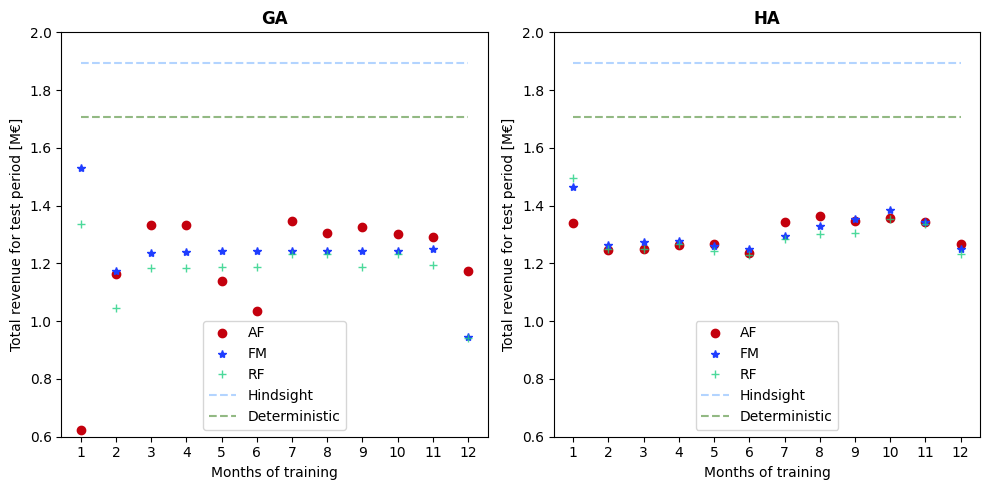

In [620]:
#-------------------OVERVIEW PLOT
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.transforms as mtrans
import matplotlib.markers as markers

results_to_plot = [
    [results_s_all, results_s_fp, results_s_model],
    [results_m_all, results_m_fp, results_m_model],
    [results_s_all_PD, results_s_fp_PD, results_s_model_PD],
    [results_m_all_PD, results_m_fp_PD, results_m_model_PD],
    [results_s_all_PD_retrained, results_s_fp_PD_retrained, results_s_model_PD_retrained],
    [results_m_all_PD_retrained, results_m_fp_PD_retrained, results_m_model_PD_retrained]
]

plot_titles = [
    "GA",
    "HA",
    "GAPD",
    "HAPD",
    "GAPDR",
    "HAPDR",
]

# fig, axs = plt.subplots(2,3, figsize=(15,10))
# xs = range(1,13)
# optimals = np.array([np.sum(result_opt['obj'])/(1e6) for _ in xs])
# deterministics = np.array([np.sum(result_det_strict['obj'])/(1e6) for _ in xs])
# for i, result_list in enumerate(results_to_plot):
#     idx2 = int(np.floor((i/2)%3))
#     idx1 = int(i%2)
#     # print(f"idx1: {idx1}, idx2: {idx2}")
#     axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[0]), 'o', color=red, label="AF")
#     axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[2]), '*', color=blue, label="FM")
#     axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[1]), '+', color=green, alpha=0.8, label="RF")
#     axs[idx1, idx2].plot(xs, optimals, '--', color=cblue, label="Hindsight")
#     # axs[idx1, idx2].plot(xs, oracles[i]-0.03, '--', color="grey", label="Oracle")
#     axs[idx1, idx2].plot(xs, deterministics, '--', color=cgreen, label="Deterministic")
#     axs[idx1, idx2].set_title(plot_titles[i], fontweight="bold")
#     if idx2 > 0:
#         axs[idx1, idx2].legend(loc="lower right")
#     else:
#         axs[idx1, idx2].legend()
#     axs[idx1, idx2].set_xlabel("Months of training")
#     axs[idx1, idx2].set_ylabel("Total revenue for test period [M€]")
#     axs[idx1, idx2].set_ylim(0.6, 2)
#     axs[idx1, idx2].set_xticks(xs)

#------------------------------------------------------------------------
#-----------------------------------------ALL THE OTHERS-------------------------
#------------------------------------------------------------------------



def plot_others(save=False):

    results_to_plot = [
        [results_s_all_PD, results_s_fp_PD, results_s_model_PD],
        [results_m_all_PD, results_m_fp_PD, results_m_model_PD],
        [results_s_all_PD_retrained, results_s_fp_PD_retrained, results_s_model_PD_retrained],
        [results_m_all_PD_retrained, results_m_fp_PD_retrained, results_m_model_PD_retrained]
    ]

    plot_titles = [
        "GAPD",
        "HAPD",
        "GAPDR",
        "HAPDR",
    ]

    fig, axs = plt.subplots(2,2, figsize=(10,10))
    xs = range(1,13)
    optimals = np.array([np.sum(result_opt['obj'])/(1e6) for _ in xs])
    deterministics = np.array([np.sum(result_det_strict['obj'])/(1e6) for _ in xs])
    for i, result_list in enumerate(results_to_plot):
        idx2 = int(np.floor((i/2)%3))
        idx1 = int(i%2)
        # print(f"idx1: {idx1}, idx2: {idx2}")
        axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[0]), 'o', color=red, label="AF")
        axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[2]), '*', color=blue, label="FM")
        axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[1]), '+', color=green, alpha=0.8, label="RF")
        axs[idx1, idx2].plot(xs, optimals, '--', color=cblue, label="Hindsight")
        # axs[idx1, idx2].plot(xs, oracles[i]-0.03, '--', color="grey", label="Oracle")
        axs[idx1, idx2].plot(xs, deterministics, '--', color=cgreen, label="Deterministic")
        axs[idx1, idx2].set_title(plot_titles[i], fontweight="bold")
        if idx2 > 0:
            axs[idx1, idx2].legend(loc="lower right")
        else:
            axs[idx1, idx2].legend()
        axs[idx1, idx2].set_xlabel("Months of training")
        axs[idx1, idx2].set_ylabel("Total revenue for test period [M€]")
        axs[idx1, idx2].set_ylim(1.6, 1.92)
        axs[idx1, idx2].set_xticks(xs)

    fig.tight_layout()
    if save:
        fig.savefig("./pdfs/2020_results_OTHERS.pdf")



#------------------------------------------------------------------------
#-----------------------------------------GA & HA-------------------------
#------------------------------------------------------------------------

def plot_ga_and_ha(save=False):

    results_to_plot = [
        [results_s_all, results_s_fp, results_s_model],
        [results_m_all, results_m_fp, results_m_model]
    ]

    plot_titles = [
        "GA",
        "HA"
    ]

    fig, axs = plt.subplots(1,2, figsize=(10,5))
    xs = range(1,13)
    optimals = np.array([np.sum(result_opt['obj'])/(1e6) for _ in xs])
    deterministics = np.array([np.sum(result_det_strict['obj'])/(1e6) for _ in xs])
    for i, result_list in enumerate(results_to_plot):
        axs[i].plot(xs, get_scaled_objs(result_list[0]), 'o', color=red, label="AF")
        axs[i].plot(xs, get_scaled_objs(result_list[2]), '*', color=blue, label="FM")
        axs[i].plot(xs, get_scaled_objs(result_list[1]), '+', color=green, alpha=0.8, label="RF")
        axs[i].plot(xs, optimals, '--', color=cblue, label="Hindsight")
        # axs[idx1, idx2].plot(xs, oracles[i]-0.03, '--', color="grey", label="Oracle")
        axs[i].plot(xs, deterministics, '--', color=cgreen, label="Deterministic")
        axs[i].set_title(plot_titles[i], fontweight="bold")
        axs[i].set_xlabel("Months of training")
        axs[i].set_ylabel("Total revenue for test period [M€]")
        axs[i].set_ylim(0.6, 2)
        axs[i].set_xticks(xs)
        axs[i].legend(loc="lower center")


    fig.tight_layout()
    
    # handles = []


    # af_marker = Line2D([0], [0], label='AF', color=red, marker='o', linestyle='None')
    # fm_marker = Line2D([0], [0], label='FM', color=blue, marker='*', linestyle='None')
    # fp_marker = Line2D([0], [0], label='FP', color=green, marker='+', linestyle='None')

    # hindsight_marker = Line2D([0], [0], label='Hindsight', color=cblue)
    # deterministic_marker = Line2D([0], [0], label='Deterministic', color=cgreen)
    # hindsight_marker.set_linestyle('--')
    # deterministic_marker.set_linestyle('--')
    # handles.append(af_marker) 
    # handles.append(fm_marker) 
    # handles.append(fp_marker) 
    # handles.append(hindsight_marker) 
    # handles.append(deterministic_marker) 
    # fig.legend(handles=handles, bbox_to_anchor=(0.8, 0), ncol=5)
    if save:
        fig.savefig("./pdfs/2020_results_GA_HA.pdf")

plot_ga_and_ha(True)
# plot_others(True)

In [456]:
#--------------------TESTING MISSING PRODUCTION

results_to_plot = [
    # [results_s_all, results_s_fp, results_s_model],
    # [results_m_all, results_m_fp, results_m_model],
    # [results_s_all_PD, results_s_fp_PD, results_s_model_PD],
    # [results_m_all_PD, results_m_fp_PD, results_m_model_PD],
    [results_s_all_PD_retrained, results_s_fp_PD_retrained, results_s_model_PD_retrained],
    [results_m_all_PD_retrained, results_m_fp_PD_retrained, results_m_model_PD_retrained]
]
plot_titles = [
    # "GA",
    # "HA",
    # "GAPD",
    # "HAPD",
    "GAPDR",
    "HAPDR",
]
feature_vector_names = [
    "AF",
    "FM",
    "RF"
]
for i, res_type in enumerate(results_to_plot):
    for j, res_list in enumerate(res_type):
        for k, res in enumerate(res_list):
            total_missing = np.sum(res['missing_production'])
            print(f"Model {plot_titles[i]}-{feature_vector_names[j]}-{k+1} has: {total_missing}")

Model GAPDR-AF-1 has: 315.63164649595296
Model GAPDR-AF-2 has: 12.400139247364116
Model GAPDR-AF-3 has: 47.1213717323029
Model GAPDR-AF-4 has: 57.00090269128934
Model GAPDR-AF-5 has: 63.57589477597304
Model GAPDR-AF-6 has: 71.55501132163586
Model GAPDR-AF-7 has: 71.27610505610095
Model GAPDR-AF-8 has: 61.412081725363535
Model GAPDR-AF-9 has: 54.97900871907095
Model GAPDR-AF-10 has: 25.261739405803326
Model GAPDR-AF-11 has: 62.386028795489324
Model GAPDR-AF-12 has: 7.815970093361102e-14
Model GAPDR-FM-1 has: 63.85537401013219
Model GAPDR-FM-2 has: 63.20681125762505
Model GAPDR-FM-3 has: 53.80745214119299
Model GAPDR-FM-4 has: 53.80745214119266
Model GAPDR-FM-5 has: 68.01048679163492
Model GAPDR-FM-6 has: 61.251068504475185
Model GAPDR-FM-7 has: 62.2707805824314
Model GAPDR-FM-8 has: 2.3862999803144618
Model GAPDR-FM-9 has: 1.4210854715202004e-13
Model GAPDR-FM-10 has: 7.815970093361102e-14
Model GAPDR-FM-11 has: 0.0
Model GAPDR-FM-12 has: 6.394884621840902e-14
Model GAPDR-RF-1 has: 112.

C:\Users\emilh\AppData\Local\Temp\ipykernel_28472\2016139538.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_28472\2016139538.py:67: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


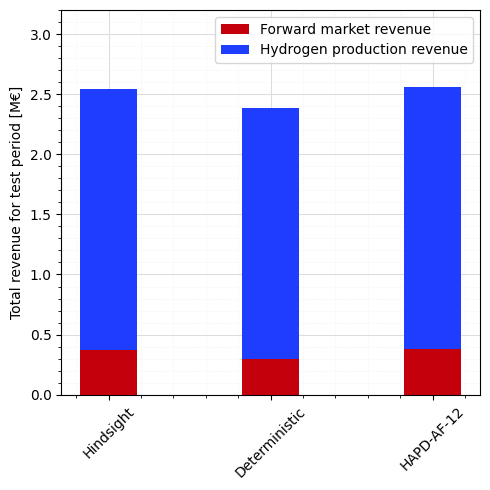

In [536]:
#-------------------REV DIST----------------------
best_res = results_m_all_PD[11]
oracle_res = results_m_all_pd_ORACLE[0]

strict_det = True
plot_penalties = True
plot_adjustments = False

forward_opt = np.sum([result_opt['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))  if (result_opt['forward_bid'][i] > 0)])
forward_det = np.sum([result_det_strict['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))  if (result_det_strict['forward_bid'][i] > 0)])
forward_best = np.sum([best_res['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))  if (best_res['forward_bid'][i] > 0)])

hprod_opt = np.sum([result_opt['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])
hprod_det = np.sum([result_det_strict['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])
hprod_best = np.sum([best_res['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])

#-------------------AUTO STUFF----------------------

def dist_plot():

    if strict_det:
        det_res = result_det_strict
    else:
        det_res = result_det


    # det_up, det_up_dw, det_pp = adjust(det_res)
    # best_up, best_up_dw, best_pp = adjust(best_res)
    # other_up, other_up_dw, other_pp = adjust(other_res)

    other = results_m_model[2]
    # xlabels = ["Hindsight", "Deterministic", "Learned", testname]
    xlabels = ["Hindsight", "Deterministic", "HAPD-AF-12"]
    # xlabels = ["Hindsight", "Deterministic", "95% quantile penalty", "Max penalty"]
    values = np.array([
        forward_opt,
        forward_det,
        forward_best
    ])

    hydrogens = np.array([
        hprod_opt,
        hprod_det,
        hprod_best
    ])

    values *= 1/1e6
    hydrogens *= 1/1e6

    xs = range(len(values))
    width = 0.35
    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.bar(xs, values, width, color=red, label="Forward market revenue")
    ax.bar(xs, hydrogens, width, bottom=values, color=blue, label="Hydrogen production revenue")
    # if plot_penalties:
    #     ax.bar(xs, penalties, width, bottom=values, color=blue, label="Penalty Loss")
    # if plot_adjustments:
    #     ax.bar(xs, adjustments, width, bottom=values, color=blue, label="Adjustment Revenue")
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xticks(xs)
    ax.set_ylabel("Total revenue for test period [M€]")
    ax.set_ylim(0, 3.2)
    fig.show()
    fig.tight_layout()
    ax.legend()
    print("\n")
    # print(f"Best is {(np.sum(best_res['obj'])-np.sum(other_res['obj']))/(np.sum(other_res['obj']))*100:.2f} % better than {testname}")
    # ax.set_title("2020 Results")
    return fig, ax

fig, ax = dist_plot()

# fig.savefig("./pdfs/rev_dist.pdf")

C:\Users\emilh\AppData\Local\Temp\ipykernel_28472\3140048785.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_28472\3140048785.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


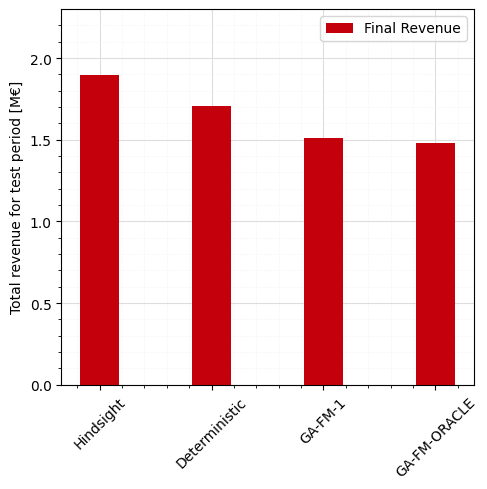

In [384]:
#-------------------PENALTY----------------------
ga_res = results_s_model[0]
ga_oracle_res = results_s_model_oracle[0]
hapd_res = results_m_all_PD[11]
hapd_oracle_res = results_m_all_pd_ORACLE[0]
ha_res = results_m_fp[0]
ha_oracle_res = results_m_fp_oracle[0]

best_res = results_m_all_PD[11]

strict_det = True
plot_penalties = False
plot_adjustments = False


def result_plot():

    if strict_det:
        det_res = result_det_strict
    else:
        det_res = result_det



    xlabels = ["Hindsight", "Deterministic", "GA-FM-1", "GA-FM-ORACLE"]
    # xlabels = ["Hindsight", "Deterministic", "HAPD-AF-12", "GA-AF-1"] 
    # xlabels = ["Hindsight", "Deterministic", "HAPD-AF-12", "HAPD-AF-ORACLE"]
    # xlabels = ["Hindsight", "Deterministic", "HAPD-AF-12", "HAPD-AF-12-OA"]

    values = np.array([
        np.sum(result_opt['obj']),
        np.sum(det_res['obj']),
        np.sum(ga_res['obj']),
        np.sum(ga_oracle_res['obj']),
        # obj(ha_oracle_res),
        # obj(best_res)
    ])

    # adjustments = np.array([
    #     0,
    #     np.sum(det_strict_up['obj'])-np.sum(det_res['obj']),
    #     np.sum(best_up['obj'])-np.sum(best_res['obj']),
    #     np.sum(result_opt_adj['obj'])-np.sum(best_res['obj']),
    # ])

    adjustments = np.array([
        0,
        np.sum(det_strict_up_dw['obj'])-np.sum(det_res['obj']),
        np.sum(best_up_dw['obj'])-np.sum(best_res['obj']),
        # obj(oracle_up_dw) - obj(hapd_oracle_res),
        np.sum(result_opt_adj['obj'])-np.sum(best_res['obj']),
    ])

    penalties = np.array([
        0,
        0,
        np.sum(best_res['missing_production'])*penalty,
        # obj(oracle_up_dw) - obj(hapd_oracle_res),
        np.sum(results_s_all[0]['missing_production'])*penalty,
    ])



    values *= 1/1e6
    adjustments *= 1/1e6
    penalties *= 1/1e6

    xs = range(len(values))
    width = 0.35
    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.bar(xs, values, width, color=red, label="Final Revenue")
    if plot_penalties:
        ax.bar(xs, penalties, width, bottom=values, color=blue, label="Penalty Loss")
    if plot_adjustments:
        ax.bar(xs, adjustments, width, bottom=values, color=blue, label="Adjustment Revenue")
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xticks(xs)
    ax.set_ylabel("Total revenue for test period [M€]")
    ax.set_ylim(0, 2.3)
    fig.show()
    fig.tight_layout()
    ax.legend()

    return fig, ax

fig, ax = result_plot()
# fig.savefig("./pdfs/eval_GA.pdf")
# fig.savefig("./pdfs/eval_HAPD.pdf")
# fig.savefig("./pdfs/adj_up_HAPD.pdf")
# fig.savefig("./pdfs/adj_dw_HAPD.pdf")
# fig.savefig("./pdfs/adj_opt.pdf")
# fig.savefig("./pdfs/adj_comparison.pdf")
# fig.savefig("./pdfs/eval_penalty.pdf")

In [304]:
def obj(res):
    return np.sum(res['obj'])

oracle_up, oracle_up_dw, oracle_pp = adjust(hapd_oracle_res)

def print_adj_res_strings(deto, detn, learno, learnn, oraco, oracn, opt_res):
    print(f"det increased with {(obj(detn) - obj(deto)) / obj(deto) * 100:.2f} % - {(obj(detn) - obj(deto)):.2f} €")
    print(f"learned increased with {(obj(learnn) - obj(learno)) / obj(learno) * 100:.2f} %  - {(obj(learnn) - obj(learno)):.2f} €")
    print(f"oracle increased with {(obj(oracn) - obj(oraco)) / obj(oraco) * 100:.2f} %  - {(obj(oracn) - obj(oraco)):.2f} €")
    print(f"learned is {(obj(learnn) - obj(detn)) / obj(detn) * 100:.2f} % better than det")
    print(f"oracle is {(obj(oracn) - obj(learnn)) / obj(learnn) * 100:.2f} % better than learned")
    print(f"hindsight is {(obj(opt_res) - obj(learnn)) / obj(learnn) * 100:.2f} % better than learned")

print_adj_res_strings(
    result_det_strict, 
    det_strict_up_dw, 
    best_res,
    best_up_dw,
    hapd_oracle_res,
    oracle_up_dw,
    result_opt
    )

det increased with 7.73 % - 131968.86 €
learned increased with 1.58 %  - 28710.74 €
oracle increased with 0.86 %  - 15862.96 €
learned is 0.61 % better than det
oracle is 0.72 % better than learned
hindsight is 2.26 % better than learned


0.8571428571428571

In [538]:

def print_bal_info(res):
    b = np.sum(res['bought'])
    s = np.sum(res['sold'])
    e = np.sum([res['sold'][i]*prices_S[t] for i, t in enumerate(range(idx_start, idx_end))])
    p = np.sum([res['bought'][i]*prices_B[t] for i, t in enumerate(range(idx_start, idx_end))])
    f = np.sum([res['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))])
    h = np.sum([res['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])
    o = np.sum(res['obj'])
    # print("Total: ", s-b)
    # print("Sold: ", s, f" ({s / (s+b)*100:.2f}) %")
    # print("Bought: ", b, f" ({b / (s+b)*100:.2f}) %")
    print("Sum €: ", e+p)
    print("Total €: ", e-p)
    print("Sold €: ", e, f" ({e / (e+p)*100:.2f}) %")
    print("Bought €: ", p, f" ({p / (e+p)*100:.2f}) %")
    print("% of rev: ", (e+p)/(o-(e-p))*100)
    print("forward €: ", f)
    print("hydrogen €: ", h)
    print("Obj: ", o)
    print("Should-be-obj: ", f+h+e-p)

                

# print("\nOptimal")
# print_bal_info(result_opt)
print("\nDeterministic")
print_bal_info(result_det_strict)
print("\nLearned")
print_bal_info(best_res)


Deterministic
Sum €:  489357.6240289863
Total €:  -202726.38055124585
Sold €:  143315.62173887025  (29.29) %
Bought €:  346042.0022901161  (70.71) %
% of rev:  25.60925424371745
forward €:  -177553.54624839427
hydrogen €:  2088415.9999999995
Obj:  1708136.0732003595
Should-be-obj:  1708136.0732003592

Learned
Sum €:  257451.04674622352
Total €:  -83550.5435850937
Sold €:  86950.2515805649  (33.77) %
Bought €:  170500.7951656586  (66.23) %
% of rev:  13.50602535761535
forward €:  -270925.98711033585
hydrogen €:  2177119.999999999
Obj:  1822643.4693045695
Should-be-obj:  1822643.4693045695


In [594]:
buying_F = 0
buying_H = 0
neg_f = 0
pos_f = 0
b_count = 0
s_count = 0
n_count = 0
b_exp = 0
s_exp = 0
n_exp = 0
hfc_count = 0
lfc_count = 0
count = 0
reald = 0
for i, t in enumerate(range(idx_start,idx_end)):
    if round(prices_F[t], 0) < (round(prices_B[t], 0) - 0.01):
        b_count += 1
        b_exp += prices_B[t] - prices_F[t]
        if best_res['bought'][i] > 0.01:
            reald += realized[t]
            count += 1
            buying_H += best_res['h_prod'][i]
            buying_F += best_res['forward_bid'][i]
            if features["production_FC"][t]*10 > realized[t] + 0.01:
                hfc_count += 1
            elif features["production_FC"][t]*10 < realized[t] - 0.01:
                lfc_count += 1

            if best_res['forward_bid'][i] > 0:
                pos_f += 1
            elif best_res['forward_bid'][i] < 0:
                neg_f += 1

        # if result_det_strict['bought'][i] > 0.01:
        #     buying_H += result_det_strict['h_prod'][i]
        #     buying_F += result_det_strict['forward_bid'][i]
        #     if features["production_FC"][t]*10 > realized[t] + 0.01:
        #         hfc_count += 1
        #     elif features["production_FC"][t]*10 < realized[t] - 0.01:
        #         lfc_count += 1
        #     if result_det_strict['forward_bid'][i] > 0:
        #         pos_f += 1
        #     elif result_det_strict['forward_bid'][i] < 0:
        #         neg_f += 1


    elif round(prices_F[t], 0) > round(prices_S[t], 0) + 0.01:
        s_count += 1
        s_exp += prices_F[t] - prices_S[t]
    else:
        n_count += 1


print("Buying pen: ", b_count, f" %: {b_count/(b_count+s_count+n_count)*100:.2f}, exp: {b_exp/idx_end}")
print("Selling pen: ", s_count, f" %: {s_count/(b_count+s_count+n_count)*100:.2f}, exp: {s_exp/idx_end}")
print("Balanced: ", n_count, f" %: {n_count/(b_count+s_count+n_count)*100:.2f}")
print("Buying h: ", buying_H)
print("Buying f: ", buying_F)
print("Pos f: ", pos_f)
print("Neg f: ", neg_f)
print("lfc : ", lfc_count)
print("hfc: ", hfc_count)
print("reald: ", reald)
print("Count: ", count)


Buying pen:  1840  %: 21.00, exp: 3.936722602739724
Selling pen:  3413  %: 38.96, exp: 3.216237442922381
Balanced:  3507  %: 40.03
Buying h:  6420.0
Buying f:  -2443.1292466472123
Pos f:  379
Neg f:  560
lfc :  252
hfc:  627
reald:  3027.892156862748
Count:  939


In [596]:
3027.892156862748/939

3.224592286328805

In [595]:
buying_F = 0
buying_H = 0
neg_f = 0
pos_f = 0
b_count = 0
s_count = 0
n_count = 0
b_exp = 0
s_exp = 0
n_exp = 0
hfc_count = 0
lfc_count = 0
hfc = 0
lfc = 0
count = 0
reald = 0
for i, t in enumerate(range(idx_start,idx_end)):
    buying_H += best_res['h_prod'][i]
    reald += realized[t]
    count += 1
    if best_res['forward_bid'][i] > 0:
        pos_f += 1
    elif best_res['forward_bid'][i] < 0:
        neg_f += 1
    if features["production_FC"][t]*10 > realized[t] + 0.01:
        hfc_count += 1
        hfc += features["production_FC"][t]*10 - realized[t]
    elif features["production_FC"][t]*10 < realized[t] - 0.01:
        lfc_count += 1
        lfc += realized[t] - features["production_FC"][t]*10


print("Buying h: ", buying_H)
print("Buying f: ", buying_F)
print("Pos f: ", pos_f)
print("Neg f: ", neg_f)
print("lfc count : ", lfc_count)
print("hfc count: ", hfc_count)
print("lfc : ", lfc)
print("hfc: ", hfc)
print("reald: ", reald)
print("count: ", count)

Buying h:  61850.0
Buying f:  0
Pos f:  2655
Neg f:  6105
lfc count :  4165
hfc count:  4118
lfc :  4300.161932694222
hfc:  4054.9841905320127
reald:  39517.20588235282
count:  8760


In [598]:
obj(result_opt) - obj(best_res)

70576.50324444962

In [557]:
np.sum(realized) # 79278.28431372548
np.sum(features['production_FC'])*10 # 78980.68047501307

78980.68047501307

In [534]:
r = result_opt
for i, t in enumerate(range(idx_start, idx_end)):
    if (r['bought'][i] > 0):
        print(f"fp={prices_F[t]}, sp={prices_S[t]}, bp={prices_B[t]}, realized={realized[t]}")
        print(f"hprod={r['h_prod'][i]:.2f}, fb={r['forward_bid'][i]:.2f}, b={r['bought'][i]:.2f}, s={r['sold'][i]:.2f}")

fp=30.34, sp=25.0, bp=30.34, realized=7.450980392156863
hprod=10.00, fb=10.00, b=12.55, s=0.00
fp=30.6, sp=30.6, bp=30.6, realized=6.078431372549019
hprod=10.00, fb=10.00, b=13.92, s=0.00
fp=45.16, sp=25.0, bp=45.16, realized=3.5784313725490193
hprod=0.00, fb=3.58, b=0.00, s=0.00
fp=44.06, sp=26.0, bp=44.06, realized=3.5784313725490193
hprod=0.00, fb=3.58, b=0.00, s=0.00
fp=29.71, sp=16.5, bp=29.71, realized=9.705882352941176
hprod=10.00, fb=10.00, b=10.29, s=0.00
fp=0.14, sp=0.14, bp=0.14, realized=9.852941176470587
hprod=10.00, fb=10.00, b=10.15, s=0.00
fp=9.92, sp=9.92, bp=9.92, realized=10.0
hprod=10.00, fb=10.00, b=10.00, s=0.00
fp=24.48, sp=22.0, bp=24.48, realized=10.0
hprod=10.00, fb=10.00, b=10.00, s=0.00
fp=26.68, sp=22.0, bp=26.68, realized=10.0
hprod=10.00, fb=10.00, b=10.00, s=0.00
fp=37.9, sp=37.9, bp=37.9, realized=8.627450980392158
hprod=0.00, fb=10.00, b=1.37, s=0.00
fp=38.11, sp=38.11, bp=38.11, realized=7.549019607843137
hprod=0.00, fb=10.00, b=2.45, s=0.00
fp=35.35,

## Wind stuff

27.45 % better with electrolyzer
30.86 % better with electrolyzer when Forecasted


<BarContainer object of 2 artists>

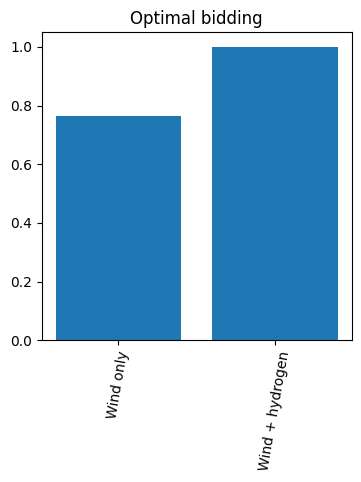

In [5]:

def calc_wind_only(forecasted=True, idx_start=0, idx_end=len(prices_F)):
    wind_only_obj = []
    for t in range(idx_start, idx_end):
        if forecasted:
            forward_bid = forecast[t]
        else:
            forward_bid = realized[t]
        d = realized[t] - forward_bid
        traded = realized[t] - forward_bid
        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + sold * prices_S[t]
            - bought * prices_B[t]
        )
        wind_only_obj.append(obj)
    return np.sum(wind_only_obj)

def calc_wind_and_hydro(forecasted=True, idx_start=0, idx_end=len(prices_F)):
    wind_and_hydro_obj = []
    for t in range(idx_start, idx_end):
        
        if prices_F[t] > price_H:
            if forecasted:
                forward_bid = forecast[t]
            else:
                forward_bid = realized[t]
        else:
            forward_bid = 0

        forward_bid = np.maximum(forward_bid,0)
        d = realized[t] - forward_bid

        h_prod = get_hydro_opt_dual_price(d, price_H, prices_S[t], prices_B[t], max_elec)
        traded = realized[t] - forward_bid - h_prod
        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + sold * prices_S[t]
            - bought * prices_B[t]
        )
        wind_and_hydro_obj.append(obj)
    return np.sum(wind_and_hydro_obj)
    
xticks = ["Wind only", "Wind + hydrogen"]
obj_values = [calc_wind_only(), calc_wind_and_hydro()]/calc_wind_and_hydro()
idx = np.asarray([i for i in range(len(xticks))])

print(f"{(calc_wind_and_hydro(False)-calc_wind_only(False))/calc_wind_only(False)*100:.2f} % better with electrolyzer")
print(f"{(calc_wind_and_hydro()-calc_wind_only())/calc_wind_only()*100:.2f} % better with electrolyzer when Forecasted")

fig, ax = plt.subplots(figsize = (4,4))
ax.set_xticks(idx, )
ax.set_xticklabels(xticks, rotation=80)
ax.set_title("Optimal bidding")
ax.bar(range(len(obj_values)), obj_values)

## Price analysis

##### Formatting price data

In [101]:
years = [2019, 2020]
yearly_separated_prices = np.array([prices_F[:year], prices_F[year:]])
yearly_separated_prices_days = [[], []]

# Reformat prices to be an array of days
for idx_year, f_prices in enumerate(yearly_separated_prices):
    current_day = np.empty(24)
    for i, price in enumerate(f_prices):
        if i%24 == 0 and i != 0:
            yearly_separated_prices_days[idx_year].append(current_day)
            current_day = np.empty(24)
        current_day[i%24] = price
    yearly_separated_prices_days[idx_year].append(current_day)

# We now have yearly_separated_prices_days = [[365 days], [366 days]]

##### Plotting hourly mean prices

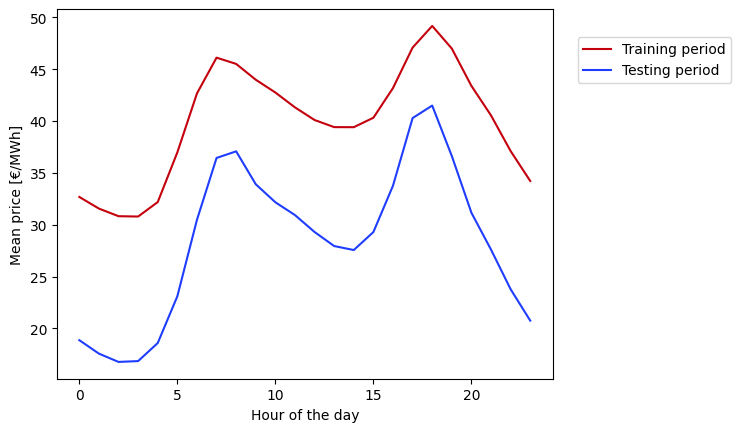

In [36]:

df_train = pd.DataFrame(yearly_separated_prices_days[0])
df_test = pd.DataFrame(yearly_separated_prices_days[1])
# lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1))

xs = range(24)
f = plt.figure()
plt.plot(xs, df_train.mean(), label="Training period", color=red)
plt.plot(xs, df_test.mean(), label="Testing period", color=blue)
plt.xlabel("Hour of the day")
plt.ylabel("Mean price [€/MWh]")
lgd = plt.legend(loc=(1.05,0.8))
# plt.grid()
# plt.tight_layout()
plt.show()
f.savefig('mean_prices.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


##### K-medoids clustering

In [155]:
#-------------K-medoids clustering--------------------
# Find k medoid days in each year
k = 2

# medoids is an array of depth (2(5(24)))
initial_medoids = [price_year[:k] for price_year in yearly_separated_prices_days]
final_medoids = []

for idx_period, f_prices in enumerate(yearly_separated_prices_days):
    data = np.array(yearly_separated_prices_days[idx_period])
    KMobj = KMedoids(n_clusters=k).fit(data)
    # labels = KMobj.labels_
    final_medoids.append(KMobj.cluster_centers_)



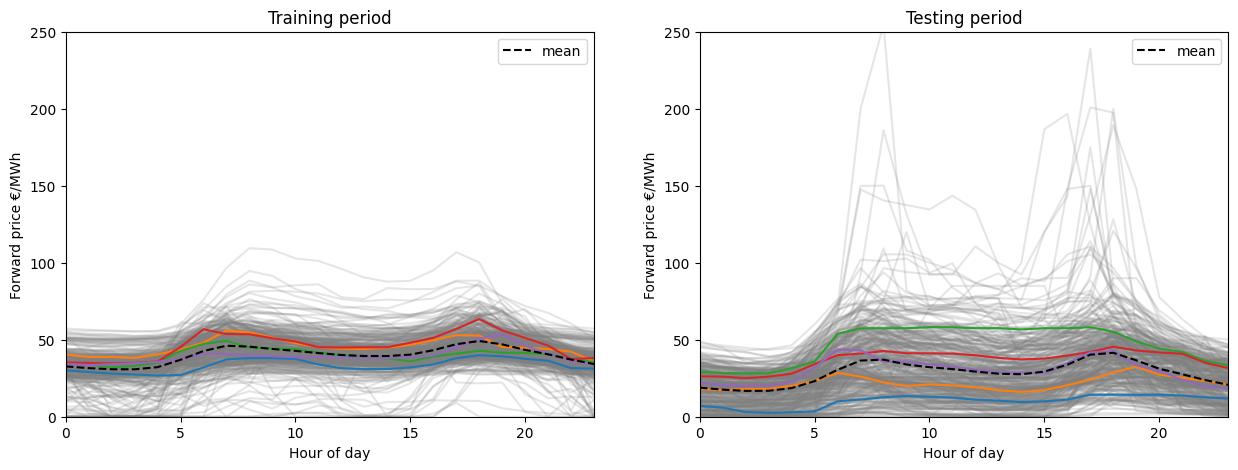

In [136]:
# ---------------Compare medoid days to each other
labels = ["Training period", "Testing period"]
dfs = [df_train, df_test]
## Plot for each year - good
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for idx, (mlist, ax) in enumerate(zip(final_medoids, axs)):
    ax.set_ylim([0, 250])
    ax.set_xlim([0, 23])
    for p in yearly_separated_prices_days[idx]:
        ax.plot(range(24), p, "grey", alpha=0.2)
    for m in mlist:
        ax.plot(range(24), m)
    ax.plot(range(24), dfs[idx].mean(), 'k--', label="mean")
    ax.set_title(labels[idx])
    ax.set_ylabel("Forward price €/MWh")
    ax.set_xlabel("Hour of day")
    ax.legend()
plt.show()
# fig.savefig('k-medoids.pdf')


##### Reduced 2021

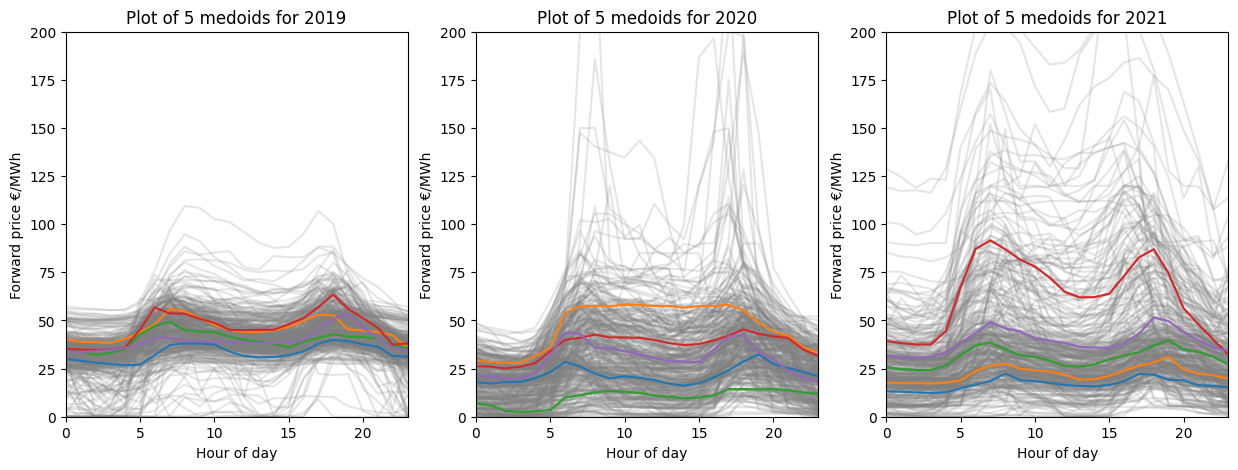

In [12]:
#----------Reduced 2021

fig, axs = plt.subplots(1, 3, figsize=(15,5))
for idx, (mlist, ax) in enumerate(zip(final_medoids, axs)):
    ax.set_ylim([0, 200])
    ax.set_xlim([0, 23])
    if idx != 2:
        for p in yearly_separated_prices_days[idx]:
            ax.plot(range(24), p, "grey", alpha=0.2)
        for m in mlist:
            ax.plot(range(24), m)
    else:
        for p in data_reduced:
            ax.plot(range(24), p, "grey", alpha=0.2)
        for m in reduced_2021_medoids:
            ax.plot(range(24), m)
    ax.set_title(f"Plot of {k} medoids for {labels[idx]}")
    ax.set_ylabel("Forward price €/MWh")
    ax.set_xlabel("Hour of day")
plt.show()
fig.savefig('k-medoids_2021_reduced.pdf')

##### In-depth statistic

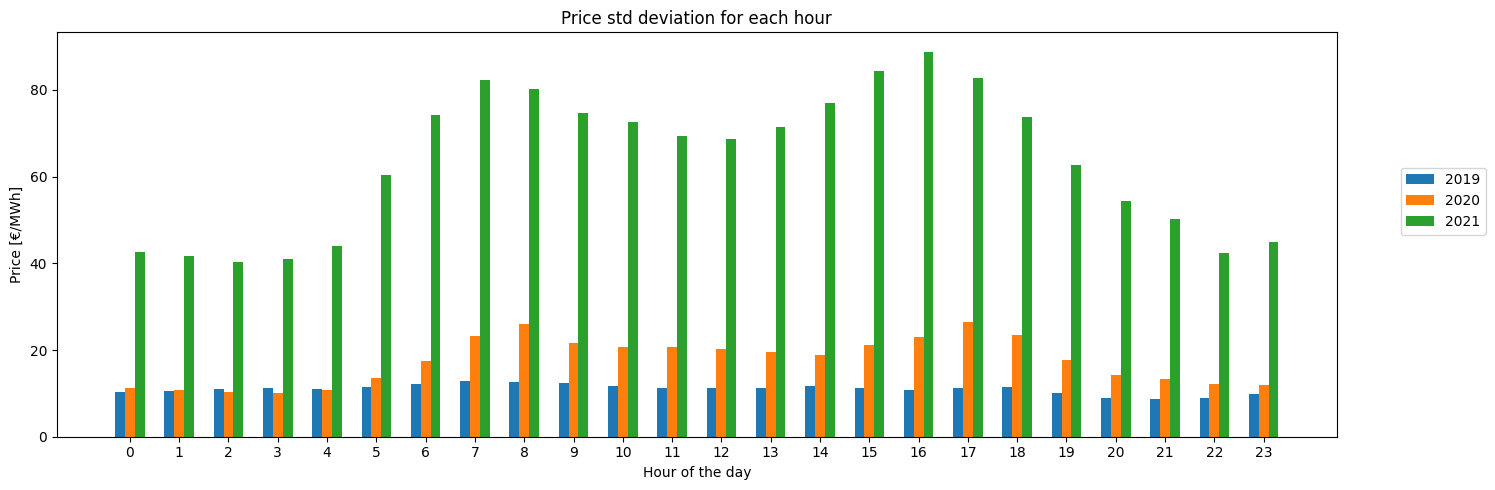

In [270]:
# df_2019.describe()
# df_2020.describe()
# df_2021.describe()


plotlabels = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
xlabels = range(24)
std_2019 = df_2019.std()
std_2020 = df_2020.std()
std_2021 = df_2021.std()

x = np.arange(len(xlabels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width, std_2019, width, label='2019')
rects2 = ax.bar(x, std_2020, width, label='2020')
rects2 = ax.bar(x + width, std_2021, width, label='2021')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Price [€/MWh]')
ax.set_xlabel('Hour of the day')
ax.set_title('Price std deviation for each hour')
ax.set_xticks(x, xlabels)
ax.legend(loc=(1.05,0.5))
fig.tight_layout()
plt.show()


In [18]:
from scipy.stats import wasserstein_distance

v_test = np.array([20-i for i in range(10)])
u_test = np.array([i for i in range(10)])

dist_matrix = np.empty((3,5,5))

all_medoids = [*final_medoids, reduced_2021_medoids]

mean_dists = {
    "2019-2020": 0,
    "2019-2021": 0,
    "2020-2021": 0,
    "2020-2021-red": 0,
    "2019-2021-red": 0,
    "2021-2021-red": 0,
    "2019-2019": 0,
    "2020-2020": 0,
    "2021-2021": 0,
    "2021-red-2021-red": 0
}


years_list = [[0, 1], [0, 2], [1, 2], [1, 3], [0, 3], [2, 3], [0, 0], [1, 1], [2, 2], [3,3]]

for i, key in enumerate(mean_dists.keys()):
    for from_idx in range(5):
        for to_idx in range(5):
            mean_dists[key] += wasserstein_distance(all_medoids[years_list[i][0]][from_idx], all_medoids[years_list[i][1]][to_idx])


mean_dists

# for y_idx in range(3):
#     for i in range(len(yearly_separated_prices_days[years_list[y_idx][0]])):
#         for j in range(len(yearly_separated_prices_days[years_list[y_idx][1]])):
            

{'2019-2020': 377.6045833333334,
 '2019-2021': 1146.2787500000002,
 '2020-2021': 1432.2016666666666,
 '2020-2021-red': 425.37000000000006,
 '2019-2021-red': 396.9585833333333,
 '2021-2021-red': 1349.8748333333333,
 '2019-2019': 135.005,
 '2020-2020': 354.4383333333333,
 '2021-2021': 1089.595,
 '2021-red-2021-red': 435.8380000000001}

In [79]:
len(yearly_separated_prices_days)

3

## Behavior analysis

C:\Users\emilh\AppData\Local\Temp\ipykernel_6252\1212225967.py:50: FutureWarning: The input object of type 'Bbox' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Bbox', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)
C:\Users\emilh\AppData\Local\Temp\ipykernel_6252\1212225967.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


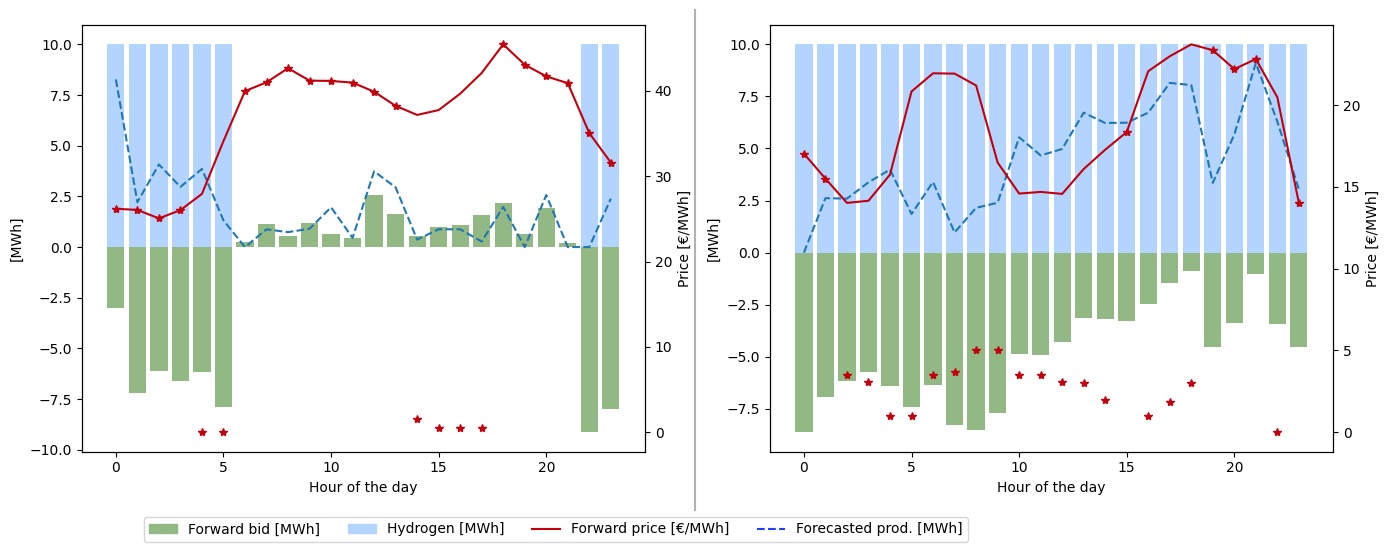

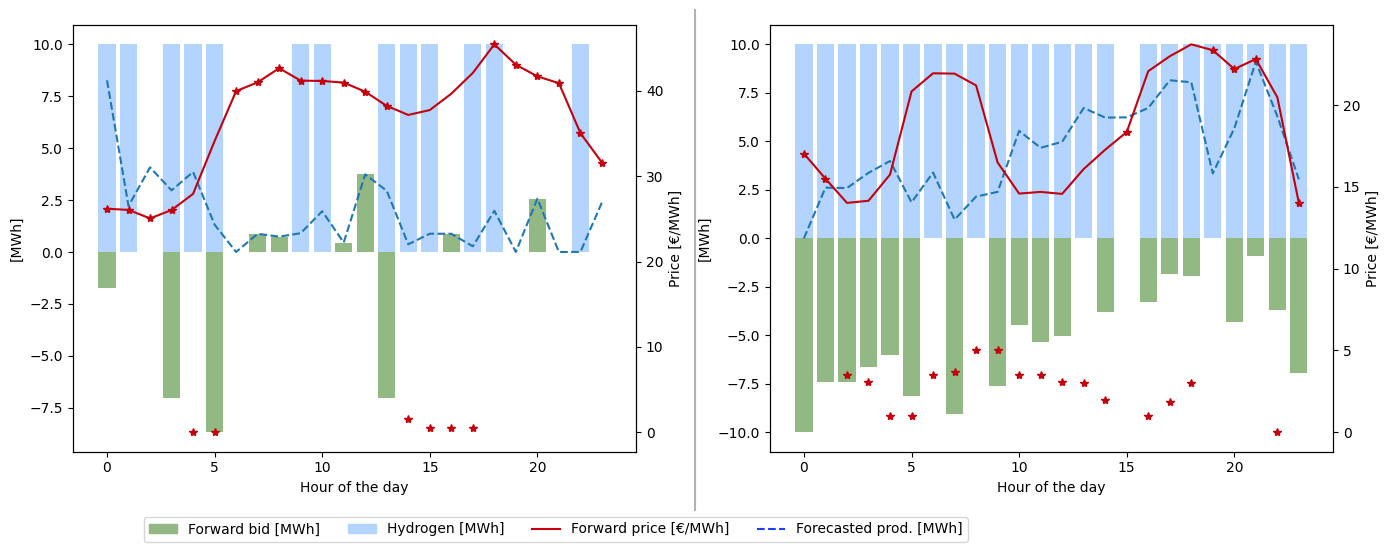

In [158]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.transforms as mtrans

offset = year
prices_F_test = prices_F[offset:]
prices_bal_test = [prices_B[offset+i] if round(prices_B[offset+i],0) < round(prices_F[offset+i],0) else prices_S[offset+i] for i in range(len(prices_S)-offset)]
prices_B_test = prices_B[offset:]
prices_S_test = prices_S[offset:]

def plot_res(res):
    fig, axs = plt.subplots(1,len(final_medoids[0]), figsize=(7*len(final_medoids[0]),5))
    handles = []
    fbid = mpatches.Patch(color=cgreen, label='Forward bid [MWh]')
    hydro = mpatches.Patch(color=cblue, label='Hydrogen [MWh]')
    fprice = Line2D([0], [0], label='Forward price [€/MWh]', color=red)
    fprod = Line2D([0], [0], label='Forecasted prod. [MWh]', color=blue)
    fprod.set_linestyle('--')
    handles.append(fbid) 
    handles.append(hydro) 
    handles.append(fprice) 
    handles.append(fprod) 
    for plotidx in range(len(final_medoids[0])):
        prods_learned = np.empty(24)
        forward_learned = np.empty(24)
        idx = KMobj.medoid_indices_[plotidx]*24
        for i, t in enumerate(range(idx, idx+24)):
            h = i%24
            prods_learned[h] = res['h_prod'][t]
            forward_learned[h] = res['forward_bid'][t]
        axs[plotidx].bar(range(24), prods_learned, label="Hydrogen", color=cblue)
        axs[plotidx].bar(range(24), forward_learned, label="Foward bid", color=cgreen)
        # axs[plotidx].plot(range(24), realized[offset+idx:offset+idx+24], 'r--', label="Realized prod.")
        axs[plotidx].plot(range(24), features.loc[offset+idx:offset+idx+23, "production_FC"]*10, '--', label="Forecasted prod.")
        ax2 = axs[plotidx].twinx()
        ax2.plot(range(24), prices_F_test[idx:idx+24], color=red, label="Forward price")
        # ax2.plot(range(24), prices_B_test[idx:idx+24], '*', color=red, label="Deficit price")
        # ax2.plot(range(24), prices_S_test[idx:idx+24], '*', color=red, label="Surplus price")
        ax2.plot(range(24), prices_bal_test[idx:idx+24], '*', color=red, label="Balancing price")
        # fig.tight_layout()
        ax2.set_ylabel("Price [€/MWh]")
        axs[plotidx].set_ylabel("[MWh]")
        axs[plotidx].set_xlabel("Hour of the day")
        # fig.legend(bbox_to_anchor=(1.25, 0.85))
    fig.legend(handles=handles, bbox_to_anchor=(0.7, 0), ncol=4)
    fig.tight_layout()
    # Get the bounding boxes of the axes including text decorations
    r = fig.canvas.get_renderer()
    get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
    bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)
    # Draw a horizontal lines at those coordinates
    for y in [1/len(final_medoids[0])*(i+1) for i in range(len(final_medoids[0])-1)]:
        line = plt.Line2D([y,y],[0,1], transform=fig.transFigure, color="grey", alpha=0.6)
        fig.add_artist(line)

    fig.show()

plot_res(best_res)
plot_res(result_det_strict)
# plot_res(result_opt)


## Production data analysis

##### Formatting production data

In [33]:
years = [2019, 2020, 2021]
yearly_separated_prods = np.array([realized[:8760], realized[8760:8760+8784], realized[8760+8784:]])
yearly_separated_prods_days = [[], [], []]

# Reformat prods to be an array of days
for idx_year, f_prods in enumerate(yearly_separated_prods):
    current_day = np.empty(24)
    for i, prod in enumerate(f_prods):
        if i%24 == 0 and i != 0:
            yearly_separated_prods_days[idx_year].append(current_day)
            current_day = np.empty(24)
        current_day[i%24] = prod
    yearly_separated_prods_days[idx_year].append(current_day)

# We now have yearly_separated_prods_days = [[365 days], [366 days], [365 days]]

C:\Users\emilh\AppData\Local\Temp\ipykernel_28472\3730098378.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  yearly_separated_prods = np.array([realized[:8760], realized[8760:8760+8784], realized[8760+8784:]])


##### K-medoids 

In [43]:
len(yearly_separated_prods_days[2])

1

In [40]:
#-------------K-medoids clustering--------------------
# Find k medoid days in each year
k = 6

# medoids is an array of depth (3(5(24)))
initial_medoids_prods = [prod_year[:k] for prod_year in yearly_separated_prods_days]
final_medoids_prods = []

for idx_year, f_prices in enumerate(yearly_separated_prods_days):
    data = np.array(yearly_separated_prods_days[idx_year])
    KMobj = KMedoids(n_clusters=k).fit(data)
    # labels = KMobj.labels_
    final_medoids_prods.append(KMobj.cluster_centers_)

ValueError: The number of medoids (6) must be less than the number of samples 1.

##### Plotting results

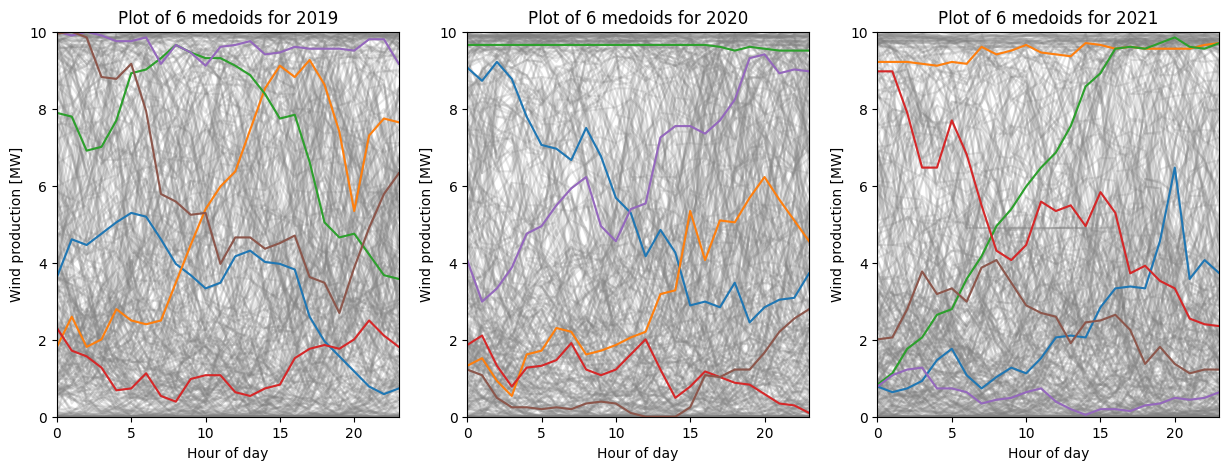

In [13]:
# ---------------Compare medoid days to each other
colors = ["green", "blue", "red"]
labels = ["2019", "2020", "2021"]

## Plot for each year - good
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for idx, (mlist, ax) in enumerate(zip(final_medoids_prods, axs)):
    ax.set_ylim([0, 10])
    ax.set_xlim([0, 23])
    for p in yearly_separated_prods_days[idx]:
        ax.plot(range(24), p, "grey", alpha=0.2)
    for m in mlist:
        ax.plot(range(24), m)
    ax.set_title(f"Plot of {k} medoids for {labels[idx]}")
    ax.set_ylabel("Wind production [MW]")
    ax.set_xlabel("Hour of day")
plt.show()


##### Constructed example plots

In [ ]:

def plot_example_behavior():
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_max = pd.read_csv("./results/x_max.csv")
    x_max1 = x_max["x_max1"][-year:].to_numpy()
    x_max2 = x_max["x_max2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_max1[i]
        hourly_x2[f"hour_{i%24}"] += x_max2[i]

    hydrogen = np.zeros(24)
    adjustments = np.zeros(24)
    
    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)
            

    adjustments[2:4] = 10
    for i in range(5):
        hourly_prices[f"hour_{i}"] += 20

    for i in range(11, 15):
        
        hourly_prices[f"hour_{i}"] -= 20

    hydrogen[12:15] += 10
    hydrogen[-2:] += 10
    adjustments[-2:] = - 10
    prices = hourly_prices.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()

    prices_bal = np.array([hourly_prices[f"hour_{i}"] for i in range(24)])
    prices_bal[2:4] -= 50

    prices_bal[10:14] -= 4
    prices_bal[20] += 30
    prices_bal[23] += 40
    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    plt.plot(range(24), prices_bal, 'r', label="Balancing price")
    
    plt.bar(range(24), hydrogen, label="hydrogen production")
    plt.bar(range(24), adjustments, label="Adjustment")
    plt.legend()
    plt.title("Adjustment example")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    # print("Hydrogen prouction: ", np.sum(hydrogen))
plot_example_behavior()

In [ ]:

def plot_example_behavior_no_adj():
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_max = pd.read_csv("./results/x_max.csv")
    x_max1 = x_max["x_max1"][-year:].to_numpy()
    x_max2 = x_max["x_max2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_max1[i]
        hourly_x2[f"hour_{i%24}"] += x_max2[i]

    hydrogen = np.zeros(24)
    adjustments = np.zeros(24)
    
    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)
            

    adjustments[2:4] = 10
    for i in range(5):
        hourly_prices[f"hour_{i}"] += 20

    for i in range(11, 15):
        
        hourly_prices[f"hour_{i}"] -= 20

    hydrogen[12:15] += 10
    hydrogen[-2:] += 10
    adjustments[-2:] = - 10
    prices = hourly_prices.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()

    prices_bal = np.array([hourly_prices[f"hour_{i}"] for i in range(24)])
    prices_bal[2:4] -= 50

    prices_bal[10:14] += 30
    prices_bal[20] += 30
    prices_bal[23] += 40
    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    # plt.plot(range(24), prices_bal, 'r', label="Balancing price")
    
    plt.bar(range(24), hydrogen, label="hydrogen production")
    # plt.bar(range(24), adjustments, label="Adjustment")
    plt.legend()
    plt.title("Deterministic example")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    # print("Hydrogen prouction: ", np.sum(hydrogen))
plot_example_behavior_no_adj()

In [ ]:

def plot_deterministic_behavior():
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_max = pd.read_csv("./results/x_max.csv")
    x_max1 = x_max["x_max1"][-year:].to_numpy()
    x_max2 = x_max["x_max2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_max1[i]
        hourly_x2[f"hour_{i%24}"] += x_max2[i]

    hydrogen = np.zeros(24)
    
    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)
        if i < 5:
            hydrogen[i] += 10


    prices = hourly_prices.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()


    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    # plt.bar(range(24), forward, label="forward bid")
    plt.bar(range(24), hydrogen, label="hydrogen production")
    plt.legend()
    plt.title("Deterministic behavior")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    # print("Hydrogen prouction: ", np.sum(hydrogen))


plot_deterministic_behavior()

In [ ]:

def plot_mean_behavior(df_qs):
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_max = pd.read_csv("./results/x_max.csv")
    x_max1 = x_max["x_max1"][-year:].to_numpy()
    x_max2 = x_max["x_max2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_max1[i]
        hourly_x2[f"hour_{i%24}"] += x_max2[i]

    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)


    prices = hourly_prices.values()
    prods = hourly_prods.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()
    hydrogen = []
    forward = []
    for i, prod, price in zip(range(24), x1s, x2s):
        hydrogen.append(np.maximum((df_qs["qH1"][i]*prod + df_qs["qH2"][i]*price + df_qs["qH3"][i]),0))
        if (price > 35.2):
            forward.append(np.maximum((df_qs["qF1"][i]*prod + df_qs["qF2"][i]*price + df_qs["qF3"][i]),0))
        else:
            forward.append(0)

        # print(f'For hour {i}, FC={prod}, FP={price}, FB={(df_qs["qF1"][i]*prod + df_qs["qF2"][i]*price + df_qs["qF3"][i])}, H={(df_qs["qH1"][i]*prod + df_qs["qH2"][i]*price + df_qs["qH3"][i])}')
        

    balancing_price = np.array([hourly_prices[f"hour_{i}"] for i in range(24)])
    balancing_price[:5] += 35
    balancing_price[11:15] -= 20
    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    # plt.bar(range(24), forward, label="forward bid")
    plt.plot(range(24), balancing_price, 'r', label="balancing price")
    plt.bar(range(24), hydrogen, label="hydrogen production")
    plt.legend()
    plt.title("Learned behavior")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    print("Hydrogen prouction: ", np.sum(hydrogen))


df_initial = pd.read_csv("./results/RES_05.2_mo_24_5.csv")
plot_mean_behavior(df_initial)

## Comparing different models - 2021

In [ ]:
#----------Price domain retrained different periods
idx_end = len(prices_F)
idx_start = idx_end - 8760
print("Before printing")
results_pd_retraining = []
for i in range(24):
    init_filename = './results/RES_05.2_01_price_domain_mo21.csv'
    cqs_filename = f'./results/changing_qs_price_domain/{i+1}_month_training/RES_05.2_01_price_domain_retrained_mo'
    results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
    results_pd_retraining.append(results)
    print(f"{i+1} month training: ", np.sum(results['obj']))

print("Done printing")
objs_pd_retraining = [np.sum(result['obj']) for result in results_pd_retraining]

In [100]:

idx_start = len(prices_F)-8760
idx_end = len(prices_F)

# #---------Changing qs for medium 
# init_filename = './results/RES_05.2_mo_24_5.csv'
# cqs_filename = './results/changing_qs/RES_05.2_FINAL_v'
# result_cqs = test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end)

#-------18 months is best
result_pd_cqs = results_pd_retraining[np.argmax(objs_pd_retraining)]
result_pd_cqs_for_risky = results_pd_retraining[np.argmax(objs_pd_retraining)]
result_pd_cqs_risky = apply_risky_policy(result_pd_cqs_for_risky, idx_start, idx_end)

df_det = pd.read_csv('./results/RES_05.2_d_good_FC.csv')
det = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_for_risky = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_plus_risky = apply_risky_policy(det_for_risky, idx_start, idx_end)

# Oracle price domain
# df_price_domain_oracle = pd.read_csv('./results/RES_05.2_01_price_domain_oracle.csv')
# results_price_domain_oracle = test_price_domain(df_price_domain_oracle, idx_start, idx_end)

# Optimal everything
df_o_everything = pd.read_csv("./results/RES_05.2_o_everything.csv")
results_o = test_optimal(df_o_everything.iloc[:,1], df_o_everything.iloc[:,0], idx_start, idx_end)


Best learned revenue is 83.29 % of Optimal
Deterministic revenue is 68.34 % of Optimal


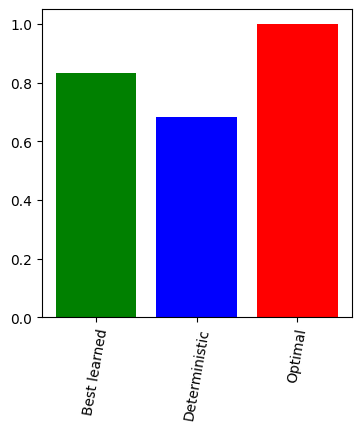

In [102]:
#------------------Without adjustment-------------

xticks = ["Best learned", "Deterministic", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs['obj']), np.sum(det['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ['green', 'blue','red']



fig, ax = plot_resulting_objectives(obj_values_1v24, xticks, (4,4), colors=colors)

# fig.savefig('2021_results.pdf')

#### With adjustment

Best learned + adj revenue is 85.37 % of Optimal
Deterministic revenue is 79.40 % of Optimal


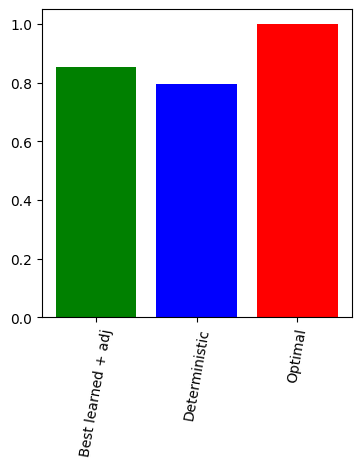

In [103]:
#------------------With adjustment-------------
xticks = ["Best learned + adj", "Deterministic", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs_risky['obj']), np.sum(det_plus_risky['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ["green", "blue", "red"]

idx = np.asarray([i for i in range(len(xticks))])

fig, ax = plot_resulting_objectives(obj_values_1v24, xticks, (4,4), colors=colors)

# fig.savefig('2021_adj_results.pdf')

##### Changing prices

**If we reduce prices to 40%:**

Leaned domains + adj revenue is 97.08 % of Optimal

Det. FC prices + adj revenue is 96.75 % of Optimal

Det. FC price+prod + adj revenue is 96.98 % of Optimal

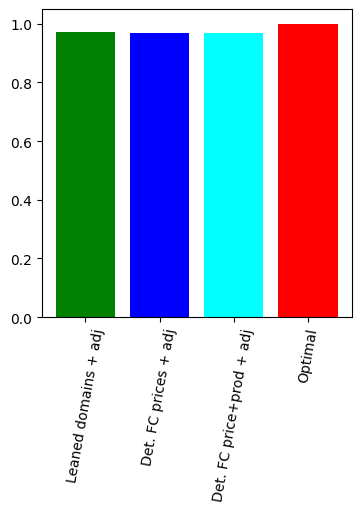

**Original prices:**

Leaned domains + adj revenue is 85.27 % of Optimal

Det. FC prices + adj revenue is 87.57 % of Optimal

Det. FC price+prod + adj revenue is 91.61 % of Optimal

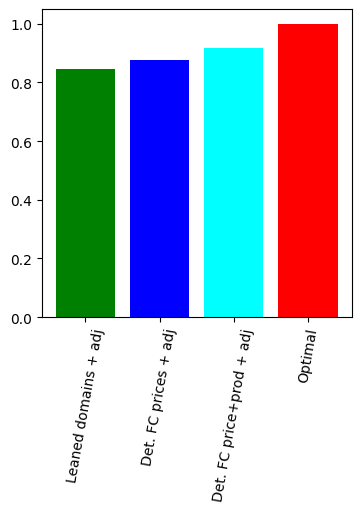

In [ ]:
#-------------------------COMPLEX
def complex_initial_easy_tester(resultfilename):
    idx_end = len(prices_F)
    idx_start = idx_end-8760
    df = pd.read_csv(f'./results/RES_05.2_{resultfilename}.csv')
    df_f = pd.DataFrame(df[["qF1", "qF2", "qF3"]])
    df_h = pd.DataFrame(df[["qH1", "qH2", "qH3"]])
    results = test_initial_plan(df_f, df_h, idx_start, idx_end, False)
    return results

for i, obj in enumerate([np.sum(results_mo1['obj']), np.sum(results_mo2['obj']), np.sum(results_mo3['obj']), np.sum(results_mo4['obj']), np.sum(results_mo5['obj']), np.sum(results_mo6['obj']), np.sum(results_mo7['obj'])]):
    print(f"Objective value {i+1} month long training: {obj}")
# print("Testing on entire year of 2021")


## Comparing different models - 2020

In [105]:
idx_start = len(prices_F)-8760*2
idx_end = len(prices_F)-8760
#------------------------------2020 different training periods

results_price_domains = []

for i in range(12):
    df = pd.read_csv(f'./results/2020/RES_05.2_01_price_domain_mo{i+1}.csv')
    res = test_price_domain(df, idx_start, idx_end)
    results_price_domains.append(res)
    print(i+1, " months: ", np.sum(res['obj']))


1  months:  1528509.9079636433
2  months:  1611479.2298431632
3  months:  1618397.2207287974
4  months:  1618904.6233922425
5  months:  1621603.923744644
6  months:  1619635.6545720906
7  months:  1613496.4165171366
8  months:  1613729.257402501
9  months:  1614003.6262537052
10  months:  1613564.6967569012
11  months:  1614447.6400987953
12  months:  1615621.0399191391


In [107]:
#----------Price domain retrained different periods
idx_start = len(prices_F)-8760*2
idx_end = len(prices_F)-8760

results_pd_retraining = []
for i in range(12):
    init_filename = './results/2020/RES_05.2_01_price_domain_mo4.csv'
    cqs_filename = f'./results/2020/changing_qs_price_domain/{i+1}_month_training/RES_05.2_01_price_domain_retrained_mo'
    results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
    results_pd_retraining.append(results)
    print(f"{i+1} month training: ", np.sum(results['obj']))

objs_pd_retraining = [np.sum(result['obj']) for result in results_pd_retraining]

1 month training:  1499134.394718748
2 month training:  1550916.2087326373
3 month training:  1563952.292966933
4 month training:  1561705.3903655182
5 month training:  1561670.8440418816
6 month training:  1568892.952808013
7 month training:  1576736.9095234517
8 month training:  1578756.7687784184
9 month training:  1601763.9962879634
10 month training:  1613279.0195606186
11 month training:  1616946.3718301333
12 month training:  1617339.7629796225


In [108]:

idx_start = len(prices_F)-8760*2
idx_end = len(prices_F)-8760

init_filename = './results/2020/RES_05.2_01_price_domain_mo12.csv'
cqs_filename = f'./results/2020/changing_qs_price_domain/changing_training/RES_05.2_trained_2_price_domain_retrained_mo'
# cqs_filename = f'./results/2020/changing_qs_price_domain/12_month_training/RES_05.2_01_price_domain_retrained_mo'
result_pd_cqs = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
result_pd_cqs_for_risky = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
result_pd_cqs_risky = apply_risky_policy(result_pd_cqs_for_risky, idx_start, idx_end)

df_det = pd.read_csv('./results/2020/RES_05.2_d_good_FC.csv')

det = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_for_risky = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_plus_risky = apply_risky_policy(det_for_risky, idx_start, idx_end)

# Oracle price domain
# df_price_domain_oracle = pd.read_csv('./results/2020/RES_05.2_01_price_domain_oracle.csv')
# results_price_domain_oracle = test_price_domain(df_price_domain_oracle, idx_start, idx_end)

# Optimal everything
df_o_everything = pd.read_csv("./results/2020/RES_05.2_o_everything.csv")
results_o = test_optimal(df_o_everything.iloc[:,1], df_o_everything.iloc[:,0], idx_start, idx_end)



FileNotFoundError: [Errno 2] No such file or directory: './results/2020/changing_qs_price_domain/changing_training/RES_05.2_trained_2_price_domain_retrained_mo1.csv'

Best learned is 87.76 % of optimal
Det. FC prices is 57.12 % of optimal
Det. FC price+prod is 76.48 % of optimal


C:\Users\emilh\AppData\Local\Temp\ipykernel_24728\1233032468.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


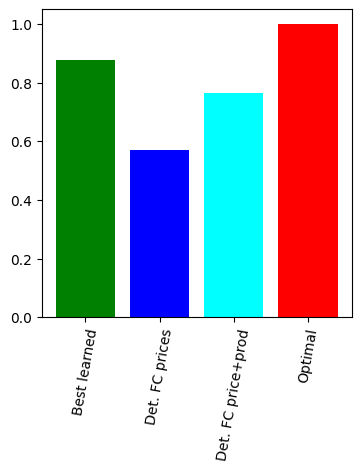

In [ ]:

#------------------Without adjustment-------------
xticks = ["Best learned", "Det. FC prices", "Det. FC price+prod", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs['obj']), np.sum(det_std['obj']), np.sum(det_good_FC['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ['green', 'blue', 'cyan', 'red']

fig, ax = plt.subplots(figsize=(4,4))
xs = range(len(xticks))
ax.bar(xs, obj_values_1v24, color=colors)
ax.set_xticks(xs)
ax.set_xticklabels(xticks, rotation=80)


for i in range(len(xticks)-1):
    print(f"{xticks[i]} is {obj_values_1v24[i]/obj_values_1v24[-1]*100:.2f} % of optimal")

fig.savefig('2020_results.pdf')
fig.show()

Best learned is 85.37 % of optimal
Det. mean prices is 79.40 % of optimal
Det. FC price+prod is 79.70 % of optimal


C:\Users\emilh\AppData\Local\Temp\ipykernel_24728\3682764570.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


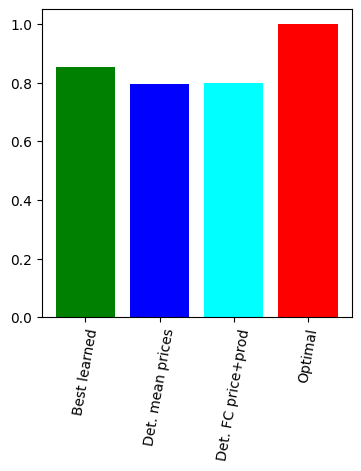

In [109]:
#------------------With adjustment-------------
xticks = ["Best learned", "Det. mean prices", "Det. FC price+prod", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs_risky['obj']), np.sum(det_plus_risky['obj']), np.sum(det_good_FC_plus_risky['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ['green', 'blue', 'cyan', 'red']



fig, ax = plt.subplots(figsize=(4,4))
xs = range(len(xticks))
ax.bar(xs, obj_values_1v24, color=colors)
ax.set_xticks(xs)
ax.set_xticklabels(xticks, rotation=80)

for i in range(len(xticks)-1):
    print(f"{xticks[i]} is {obj_values_1v24[i]/obj_values_1v24[-1]*100:.2f} % of optimal")

fig.show()

fig.savefig('2020_adj_results.pdf')

## Comparing different models - 2021 - reduced prices

In [67]:

idx_start = len(prices_F)-8760
idx_end = len(prices_F)

init_filename = './results/2021_red/RES_05.2_01_price_domain_mo12.csv'
cqs_filename = f'./results/2021_red/changing_qs_price_domain/12_month_training/RES_05.2_01_price_domain_retrained_mo'
# cqs_filename = f'./results/2020/changing_qs_price_domain/12_month_training/RES_05.2_01_price_domain_retrained_mo'
result_pd_cqs = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
result_pd_cqs_for_risky = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
result_pd_cqs_risky = apply_risky_policy(result_pd_cqs_for_risky, idx_start, idx_end)

df_det = pd.read_csv('./results/2021_red/RES_05.2_d_FC.csv')
df_det_good_FC = pd.read_csv('./results/2021_red/RES_05.2_d_good_FC.csv')

det_std = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_for_risky = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_plus_risky = apply_risky_policy(det_for_risky, idx_start, idx_end)

det_good_FC = test_optimal(df_det_good_FC["forward bid"], df_det_good_FC["hydrogen production"], idx_start, idx_end)
det_good_FC_for_risky = test_optimal(df_det_good_FC["forward bid"], df_det_good_FC["hydrogen production"], idx_start, idx_end)
det_good_FC_plus_risky = apply_risky_policy(det_good_FC_for_risky, idx_start, idx_end)

det_mean = test_optimal(df_det_mean["forward bid"], df_det_mean["hydrogen production"], idx_start, idx_end)

# Oracle price domain
# df_price_domain_oracle = pd.read_csv('./results/2020/RES_05.2_01_price_domain_oracle.csv')
# results_price_domain_oracle = test_price_domain(df_price_domain_oracle, idx_start, idx_end)

# Optimal everything
df_o_everything = pd.read_csv("./results/2021_red/RES_05.2_o_everything.csv")
results_o = test_optimal(df_o_everything.iloc[:,1], df_o_everything.iloc[:,0], idx_start, idx_end)



Best learned is 83.64 % of optimal
Det. FC prices is 64.25 % of optimal
Det. FC price+prod is 72.37 % of optimal


C:\Users\emilh\AppData\Local\Temp\ipykernel_24728\1689033366.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


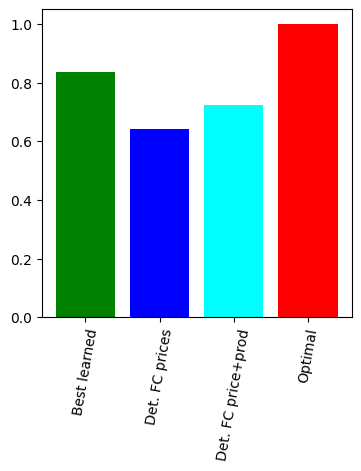

In [68]:

#------------------Without adjustment-------------
xticks = ["Best learned", "Det. FC prices", "Det. FC price+prod", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs['obj']), np.sum(det_std['obj']), np.sum(det_good_FC['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ['green', 'blue', 'cyan', 'red']

fig, ax = plt.subplots(figsize=(4,4))
xs = range(len(xticks))
ax.bar(xs, obj_values_1v24, color=colors)
ax.set_xticks(xs)
ax.set_xticklabels(xticks, rotation=80)


for i in range(len(xticks)-1):
    print(f"{xticks[i]} is {obj_values_1v24[i]/obj_values_1v24[-1]*100:.2f} % of optimal")

fig.savefig('2021_red_results.pdf')
fig.show()

Best learned is 88.55 % of optimal
Det. mean prices is 96.75 % of optimal
Det. FC price+prod is 96.98 % of optimal


C:\Users\emilh\AppData\Local\Temp\ipykernel_24728\2498853077.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


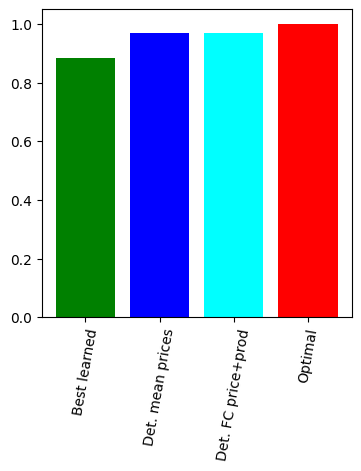

In [69]:
#------------------With adjustment-------------
xticks = ["Best learned", "Det. mean prices", "Det. FC price+prod", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs_risky['obj']), np.sum(det_plus_risky['obj']), np.sum(det_good_FC_plus_risky['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ['green', 'blue', 'cyan', 'red']



fig, ax = plt.subplots(figsize=(4,4))
xs = range(len(xticks))
ax.bar(xs, obj_values_1v24, color=colors)
ax.set_xticks(xs)
ax.set_xticklabels(xticks, rotation=80)

for i in range(len(xticks)-1):
    print(f"{xticks[i]} is {obj_values_1v24[i]/obj_values_1v24[-1]*100:.2f} % of optimal")

fig.show()

fig.savefig('2021_red_adj_results.pdf')

## Some investigation with kind of nice plots maybe

Day is 110


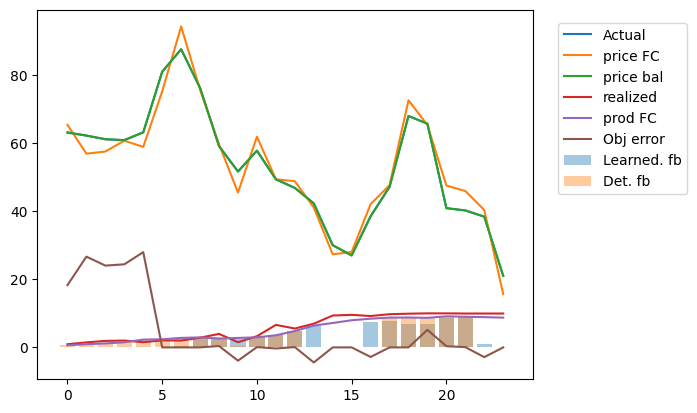

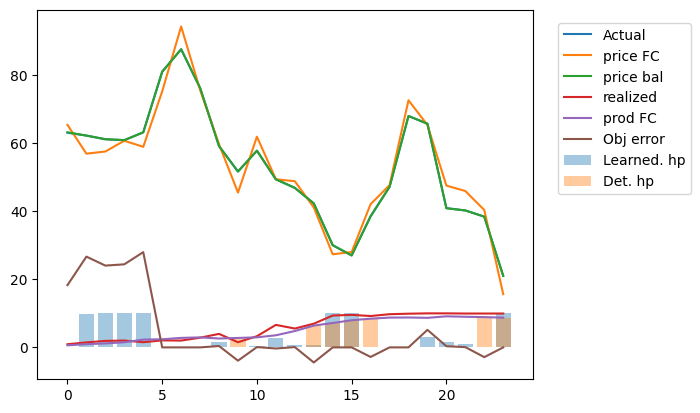

Day is 148


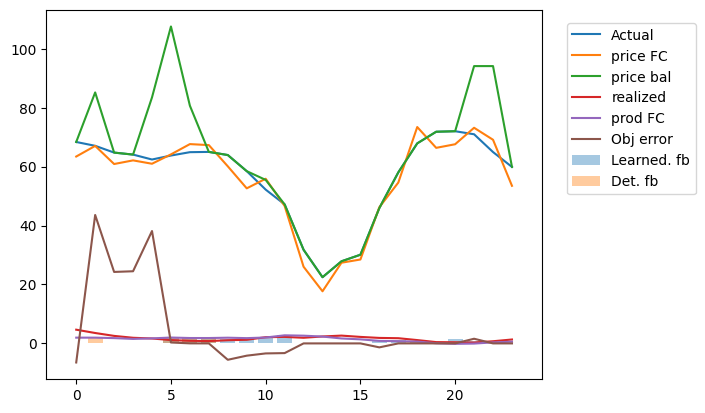

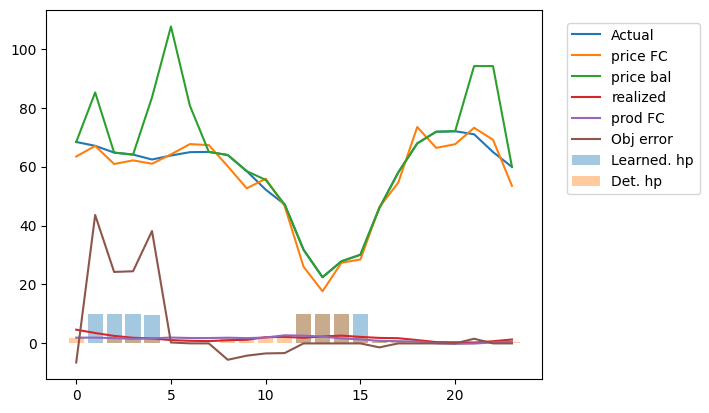

Day is 162


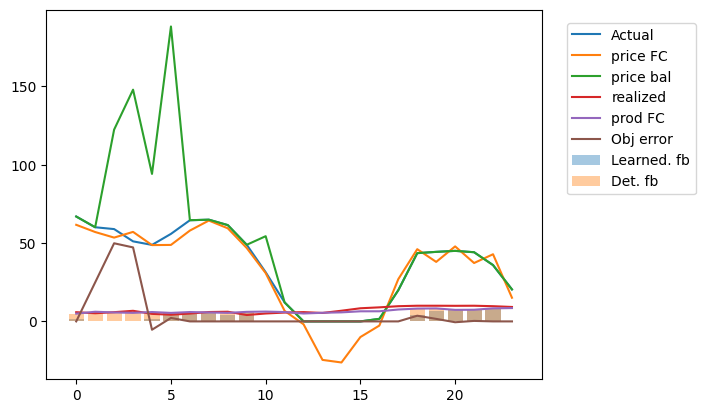

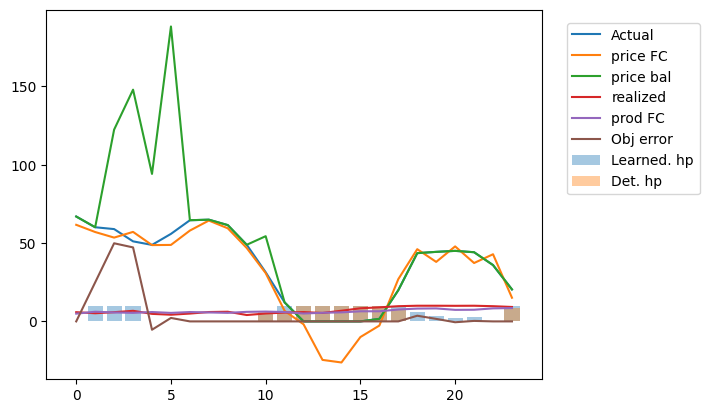

Day is 177


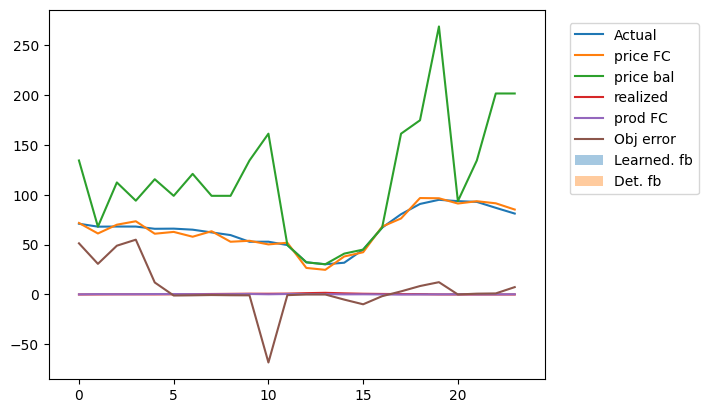

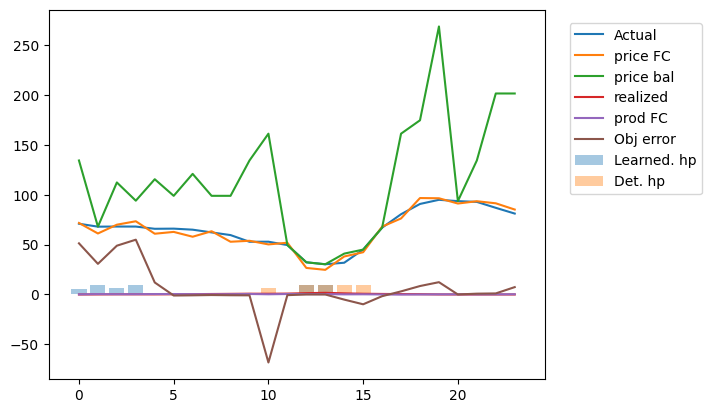

Day is 197


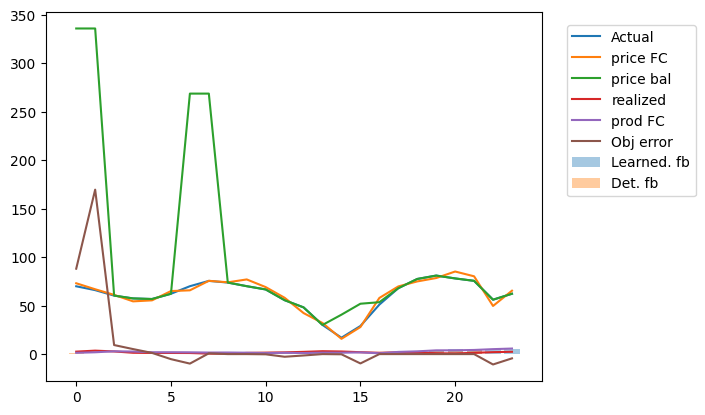

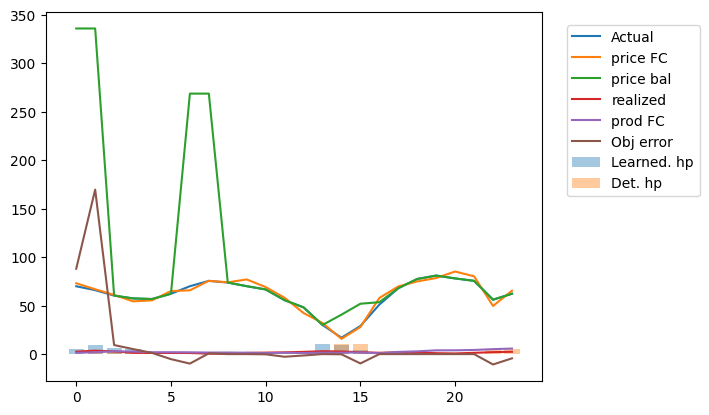

Day is 239


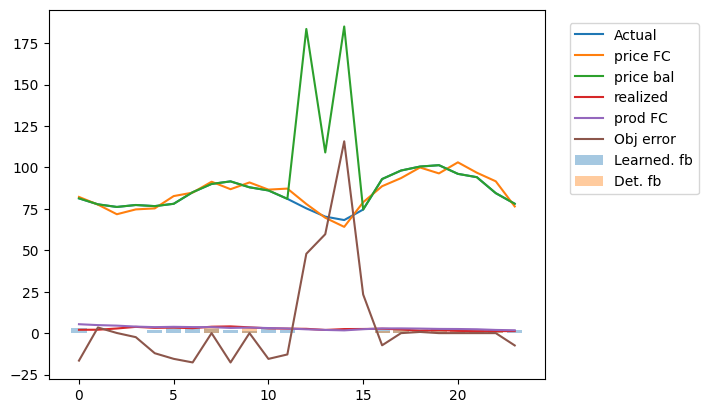

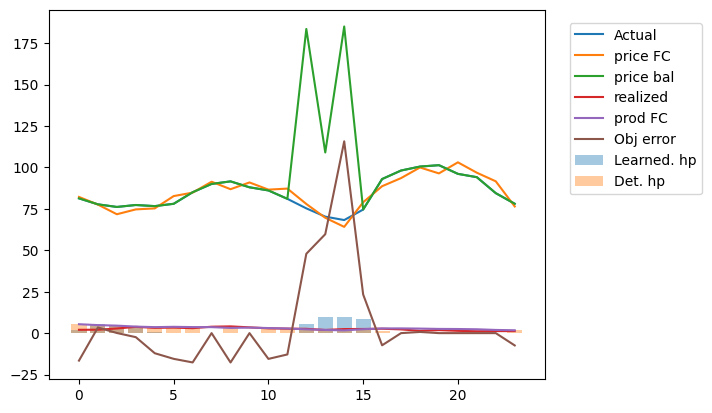

Day is 240


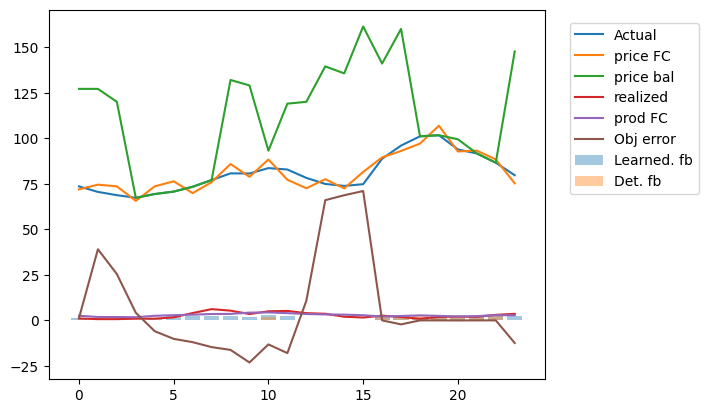

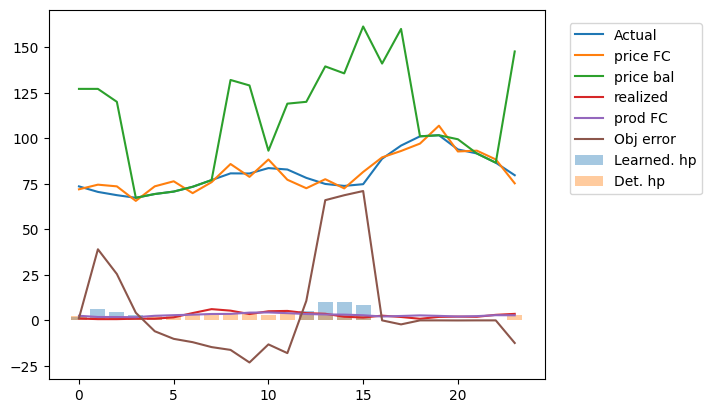

Day is 257


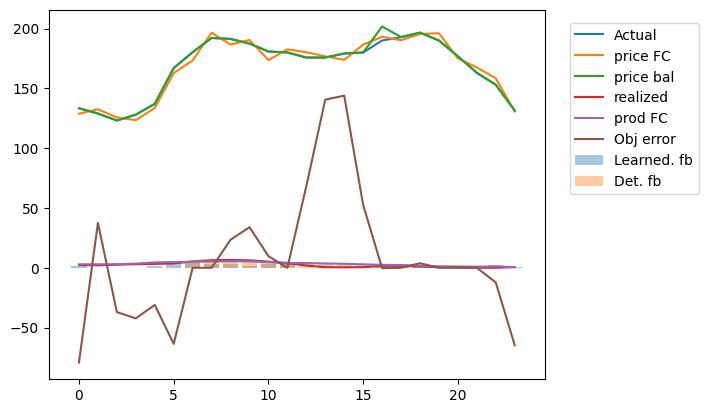

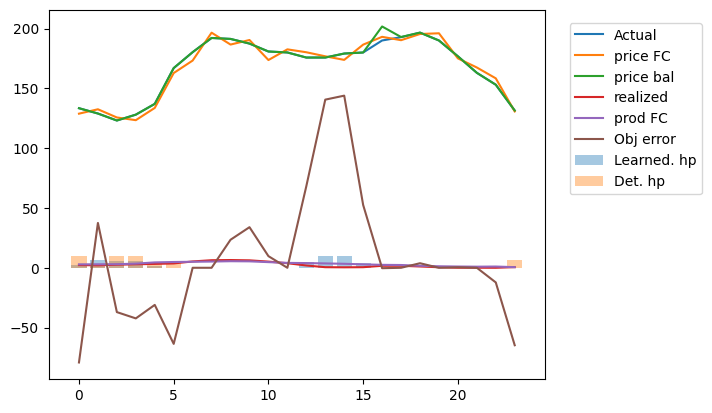

Day is 259


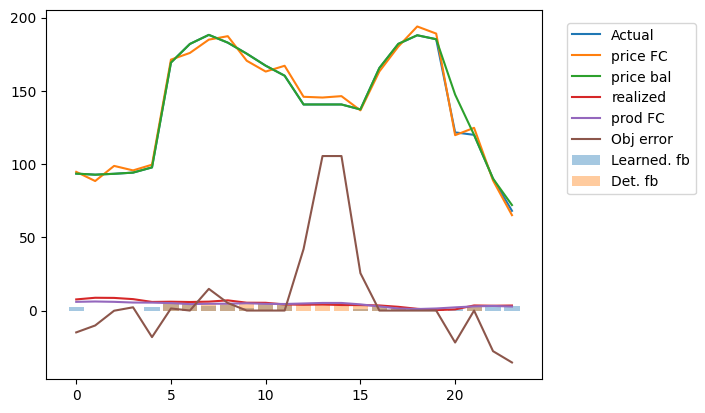

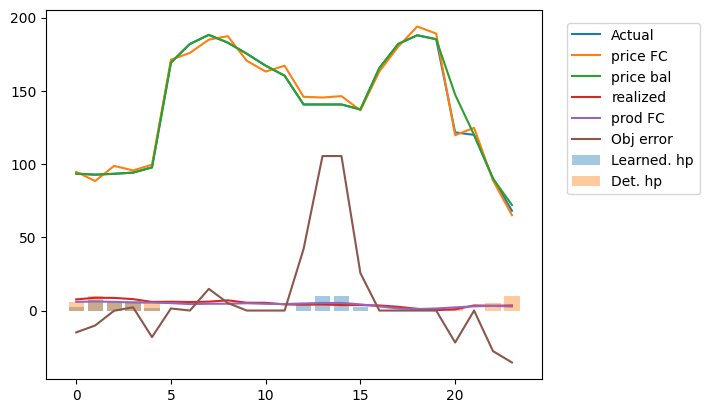

Day is 262


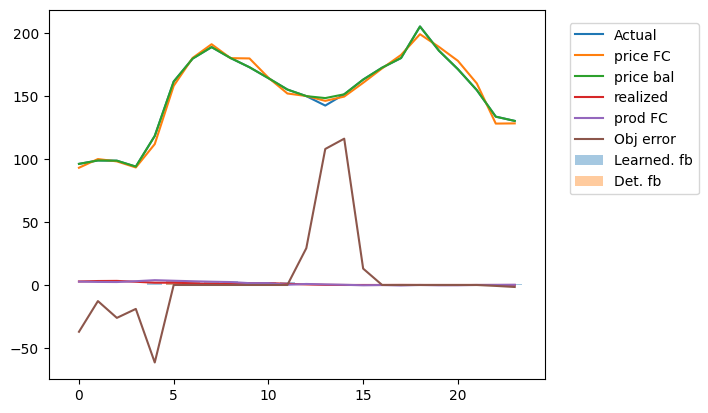

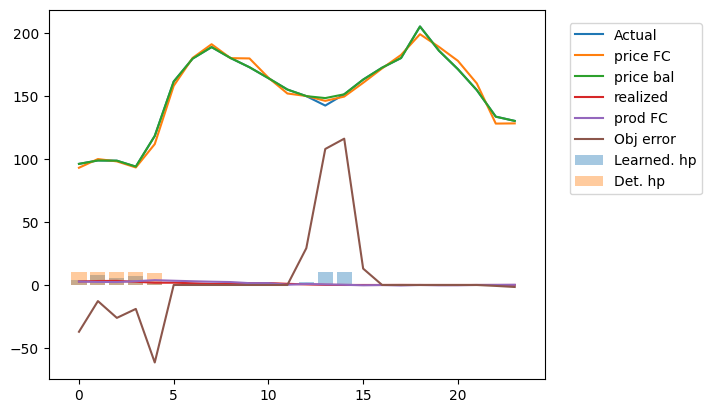

Day is 264


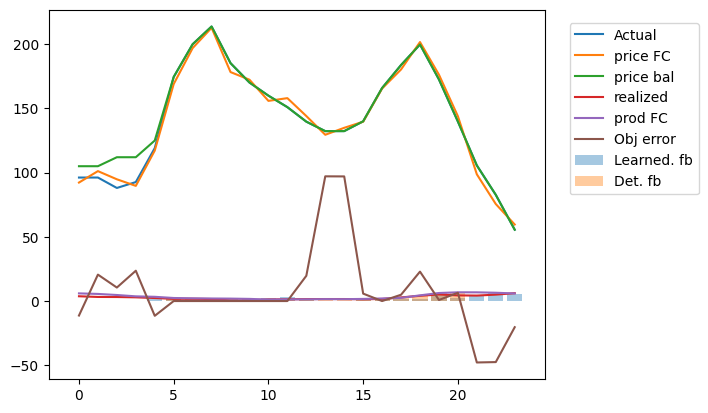

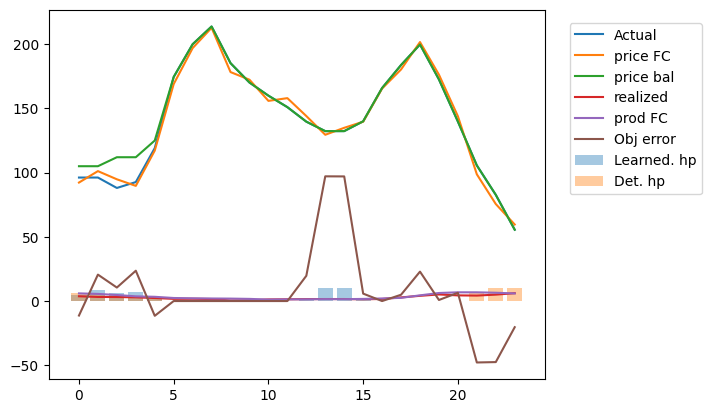

In [251]:
##--------------LEARNED vs OPTIMIZING
xs = np.array(list(range(24)))
w = 0.25
pcounter=0
for d in range(len(det_error)):
    if pcounter > 12:
        break
    if learn_error[d] > 1000:
        start = d * 24
        end = d * 24 + 24
        print(f"Day is {d}")
        # print(f"d={d}, h={h}, fp={prices_F[t]}, bp={prices_B[t]}, sp={prices_S[t]}, fc={forecast[t]}, real={realized[t]}")
        # print(f"Opt {results_o['obj'][i]:.2f}: fb={results_o['forward_bid'][i]:.2f}, hp={results_o['h_prod'][i]:.2f}, b={results_o['bought'][i]:.2f}, s={results_o['sold'][i]:.2f}, mis={results_o['missing_production'][i]:.2f}")
        # print(f"det {det_std['obj'][i]:.2f}: fb={det_std['forward_bid'][i]:.2f}, hp={det_std['h_prod'][i]:.2f}, b={det_std['bought'][i]:.2f}, s={det_std['sold'][i]:.2f}, mis={det_std['missing_production'][i]:.2f}")
        plt.figure()
        plt.plot(xs, prices_F[idx_start+start:idx_start+end], label="Actual")
        plt.plot(xs, prices_F_fc[idx_start+start:idx_start+end], label="price FC")
        plt.plot(xs, prices_bal[idx_start+start:idx_start+end], label="price bal")
        plt.plot(xs, realized[idx_start+start:idx_start+end], label="realized")
        plt.plot(xs, forecast[idx_start+start:idx_start+end], label="prod FC")
        plt.plot(xs, learn_error_hourly[start:end], label="Obj error")
        plt.bar(xs, result_cqs_risky['forward_bid'][start:end], label="Learned. fb", alpha=0.4)
        plt.bar(xs, det_std['forward_bid'][start:end], label="Det. fb", alpha=0.4)
        plt.legend(loc=(1.05, 0.5))
        plt.figure()
        plt.plot(xs, prices_F[idx_start+start:idx_start+end], label="Actual")
        plt.plot(xs, prices_F_fc[idx_start+start:idx_start+end], label="price FC")
        plt.plot(xs, prices_bal[idx_start+start:idx_start+end], label="price bal")
        plt.plot(xs, realized[idx_start+start:idx_start+end], label="realized")
        plt.plot(xs, forecast[idx_start+start:idx_start+end], label="prod FC")
        plt.plot(xs, learn_error_hourly[start:end], label="Obj error")
        plt.bar(xs, result_cqs_risky['h_prod'][start:end], label="Learned. hp", alpha=0.4)
        plt.bar(xs, det_std['h_prod'][start:end], label="Det. hp", alpha=0.4)
        plt.legend(loc=(1.05, 0.5))
        plt.show()
        pcounter += 1
        


### Only testing wind part

Deterministic revenue is 26.51 % of optimal
trained revenue is 39.26 % of optimal


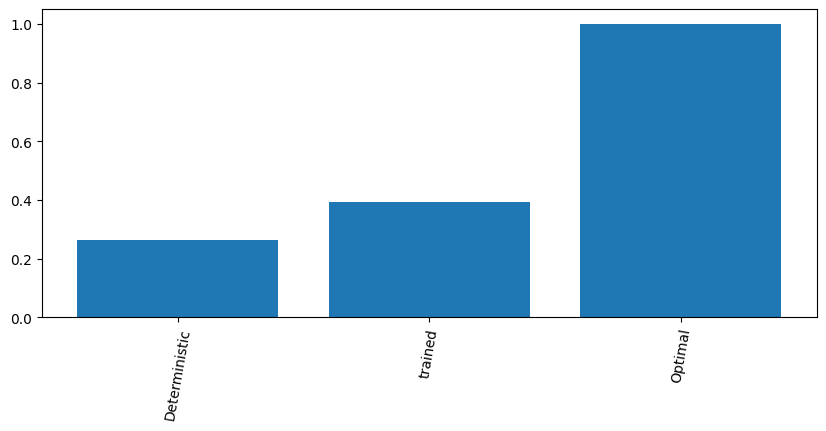

In [23]:

#----------Investing wind bidding isolated
opt_wind = [prices_F[t] * realized[t] for t in range(idx_start, idx_end)]
det_wind = [prices_F[t] * results_d_c['forward_bid'][i] - prices_B[t] * results_d_c['bought'][i] + prices_S[t] * results_d_c['sold'][i] for i, t in enumerate(range(idx_start, idx_end))]
retrained_wind = [prices_F[t] * result_cqs['forward_bid'][i] - prices_B[t] * result_cqs['bought'][i] + prices_S[t] * result_cqs['sold'][i] for i, t in enumerate(range(idx_start, idx_end))]

wind_obj_values = [np.sum(det_wind), np.sum(retrained_wind), np.sum(opt_wind)]
wind_obj_values /= np.sum(opt_wind)
wind_names = ["Deterministic", "trained", "Optimal",]

plot_resulting_objectives(wind_obj_values, wind_names)